In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.fftpack import fft, ifft

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

In [ ]:
colab=1
import os

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  working_dir='/content/drive/My Drive/Financial Programming/Project1/Updated'
  os.chdir(working_dir)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Financial Programming/Project1/Updated"

 AAPL_n.csv   ETHUSD-5m-data.csv   Project1_Crypt.ipynb		     WMT_n.csv
 AEO_n.csv    P1_2020Fall.pdf	   Project1_HFT.ipynb
 BAC_n.csv    P1.pptx		  'Project 1 Presentation.gslides'


# HFT data preprocessing

In [ ]:
filename=['AAPL_n.csv', 'AEO_n.csv', 'BAC_n.csv', 'WMT_n.csv']
aapl=pd.read_csv(filename[0],index_col=1, parse_dates=True)
aeo=pd.read_csv(filename[1],index_col=1, parse_dates=True)
bac = pd.read_csv(filename[2],index_col=1, parse_dates=True)
wmt = pd.read_csv(filename[3],index_col=1, parse_dates=True)

aapl_df = aapl.copy()
aeo_df = aeo.copy()
bac_df = bac.copy()
wmt_df = wmt.copy()

aapl_df.drop(columns='Unnamed: 0', inplace=True)
aeo_df.drop(columns='Unnamed: 0', inplace=True)
bac_df.drop(columns='Unnamed: 0', inplace=True)
wmt_df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
aapl_df.head()

marketAverage  ...  marketVolume
Date                                ...              
2019-02-01 09:30:00        167.058  ...        789821
2019-02-01 09:31:00        167.182  ...        170656
2019-02-01 09:32:00        167.051  ...        133658
2019-02-01 09:33:00        166.945  ...        120666
2019-02-01 09:34:00        167.045  ...        102236

[5 rows x 9 columns]

# Add four variables: Close Of High, Pseudo Volatility, 10 Day Moving Avg, Bollinger Band

In [ ]:
HFT = [aapl_df, aeo_df, bac_df,wmt_df]
for item in HFT:
    item['closeOfHigh'] = (item['marketHigh']-item['marketClose'])/(item['marketHigh'] - item['marketLow'])
    item['pseudoVolatility'] = (item['marketHigh']-item['marketLow'])/item['marketOpen']
    item['TypicalPrice'] = (item['marketHigh']+item['marketLow']+item['marketClose'])/3
    item['10DayMA'] = item['TypicalPrice'].rolling(window=10).mean()
    item['10DaySTD'] = item['TypicalPrice'].rolling(window=10).std()  
    item['UpperBand'] = item['10DayMA'] + (item['10DaySTD'] * 2)
    item['LowerBand'] = item['10DayMA'] - (item['10DaySTD'] * 2)
    item['Marker'] = abs(item['marketClose']/item['marketClose'].shift(1)-1)>= 0.0008

aapl_df = aapl_df.drop(columns=['TypicalPrice', '10DaySTD'])
aeo_df = aeo_df.drop(columns=['TypicalPrice', '10DaySTD'])
bac_df = bac_df.drop(columns=['TypicalPrice', '10DaySTD'])
wmt_df = wmt_df.drop(columns=['TypicalPrice', '10DaySTD'])

In [ ]:
aapl_df.head()

marketAverage  marketChangeOverTime  ...  LowerBand  Marker
Date                                                      ...                   
2019-02-01 09:30:00        167.058              0.000000  ...        NaN   False
2019-02-01 09:31:00        167.182              0.000742  ...        NaN   False
2019-02-01 09:32:00        167.051             -0.000042  ...        NaN    True
2019-02-01 09:33:00        166.945             -0.000676  ...        NaN   False
2019-02-01 09:34:00        167.045             -0.000078  ...        NaN    True

[5 rows x 15 columns]

In [ ]:
aapl_df = aapl_df.iloc[9:,:]
aeo_df = aeo_df.iloc[9:,:]
bac_df = bac_df.iloc[9:,:]
wmt_df = wmt_df.iloc[9:,:]

In [ ]:
aapl_df.head()

marketAverage  marketChangeOverTime  ...   LowerBand  Marker
Date                                                      ...                    
2019-02-01 09:39:00        167.305              0.001479  ...  166.905515   False
2019-02-01 09:40:00        167.664              0.003627  ...  166.786614    True
2019-02-01 09:41:00        167.860              0.004801  ...  166.688657    True
2019-02-01 09:42:00        167.873              0.004879  ...  166.702192   False
2019-02-01 09:43:00        167.783              0.004340  ...  166.803410   False

[5 rows x 15 columns]

In [ ]:
aeo_df["closeOfHigh"] = aeo_df["closeOfHigh"].fillna(0)
aeo_df["pseudoVolatility"] = aeo_df["pseudoVolatility"].fillna(0)

In [ ]:
print(aapl_df['Marker'][aapl_df['Marker']==True])
print(aeo_df['Marker'][aeo_df['Marker']==True])
print(bac_df['Marker'][bac_df['Marker']==True])
print(wmt_df['Marker'][wmt_df['Marker']==True])

Date
2019-02-01 09:40:00    True
2019-02-01 09:41:00    True
2019-02-01 09:45:00    True
2019-02-01 09:46:00    True
2019-02-01 09:48:00    True
                       ... 
2019-02-22 13:17:00    True
2019-02-22 14:35:00    True
2019-02-22 14:40:00    True
2019-02-22 15:55:00    True
2019-02-22 15:59:00    True
Name: Marker, Length: 521, dtype: bool
Date
2019-02-01 09:39:00    True
2019-02-01 09:40:00    True
2019-02-01 09:41:00    True
2019-02-01 09:42:00    True
2019-02-01 09:43:00    True
                       ... 
2019-02-22 15:11:00    True
2019-02-22 15:28:00    True
2019-02-22 15:32:00    True
2019-02-22 15:36:00    True
2019-02-22 15:40:00    True
Name: Marker, Length: 1404, dtype: bool
Date
2019-02-01 09:39:00    True
2019-02-01 09:41:00    True
2019-02-01 09:43:00    True
2019-02-01 09:44:00    True
2019-02-01 09:47:00    True
                       ... 
2019-02-22 11:18:00    True
2019-02-22 13:50:00    True
2019-02-22 13:51:00    True
2019-02-22 14:43:00    True
2019-02-22

# Plot DBSCAN

In [ ]:
# Plot the DBSCAN result of the data 
# Also print the labels and number of outliers
def plotDB(db, X, ticker, method):
    #db = DBSCAN(eps=2, min_samples =10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype = bool)# a generalized np.seris
    core_samples_mask[db.core_sample_indices_] = True

    fig=plt.figure(figsize=(12,8))
    unique_labels = set(db.labels_)
    print(len(unique_labels),' labels: ', unique_labels)
    n_noise_ = list(db.labels_).count(-1)
    print('outliers: ', n_noise_)

    color_list = ['r', 'g', 'c', 'b', 'm', 'y','orange', 'k', 'tan', 'gold', 'navy', 'dimgray', 'darkred', 'olive', 
                  'pink', 'slateblue', 'lightseagreen', 'bisque', 'azure', 'thistle']
    if len(unique_labels) > 20:
        unique_labels = sorted(unique_labels)[:20]
    for k in unique_labels:
        class_member_mask = (db.labels_ == k)
        
        xy = X[class_member_mask & core_samples_mask]
        
        plt.plot(xy[:, 0], xy[:,1], 'd', markerfacecolor = color_list[k], 
                markeredgecolor = 'w', markersize = 10, label = 'core points')
        
        xy2 = X[class_member_mask & ~core_samples_mask]
                
        if k == -1:
            plt.plot(xy2[:, 0], xy2[:,1], 's', markerfacecolor = 'lightblue',
                    markeredgecolor = 'b', markersize=6, label = 'outliers')
        else:
            plt.plot(xy2[:, 0], xy2[:,1], 'o', markerfacecolor = color_list[k], 
                    markeredgecolor = 'w', markersize = 10, label = 'reachable points')
                
        plt.legend()
    if method=='PCA':
        plt.xlabel('$PC_{1}$', fontsize=10)
        plt.ylabel('$PC_{2}$', fontsize=10)
    else:
        plt.xlabel('$'+ method +'_{1}'+'$', fontsize=8)
        plt.ylabel('$'+ method +'_{2}'+'$', fontsize=8)
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title('DBSCAN Clusters for %s data with %s' % (ticker, method))
    plt.grid(True, color = 'r', linestyle = ':', linewidth = 0.5)
    plt.show()


# Dimension Reduction

In [ ]:
class dimension_reduction:
    def __init__(self, ticker, df):
        self.ticker = ticker
        self.df = df
    
    def getPCA(self):
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(self.df)
        pca= PCA()
        self.pcaNewData = pca.fit_transform(normalized_data)
    
    def getTSNE(self, perplexity, init):
        normalized_data = MinMaxScaler().fit_transform(self.df)
        tsne = TSNE(perplexity = perplexity, init=init)
        self.tsneNewData = tsne.fit_transform(normalized_data)

    def getUMAP(self, n_neighbors, min_dist):
        self.umapNewData = umap.UMAP(n_neighbors = 30,
                       min_dist = 0.05,
                       metric = 'euclidean', 
                       init = 'random').fit_transform(StandardScaler().fit_transform(self.df))

    def getLLE(self, neighbors):
        normalized_data=StandardScaler().fit_transform(self.df)
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors = neighbors)
        self.lleNewData = lle.fit_transform(normalized_data)

    def fft_trans(self):
        df_trans = pd.DataFrame(fft(self.df).real, columns = self.df.columns)
        df_trans.index = self.df.index
        self.FFTNewData = df_trans
    
    def numOfGlobalMarkers(self):
        return np.count_nonzero(self.df['Marker'])

    def global_mask(self):
        return self.df['Marker']
    
    def fft_mask(self):
        if self.df.index.name =='timestamp':
            self.fftRanking=self.FFTNewData.close.sort_values(ascending=False)[0:self.numOfGlobalMarkers()]
            return [idx in self.fftRanking.index for idx in self.df.index]
        else:
            self.fftRanking=self.FFTNewData.marketClose.sort_values(ascending=False)[0:self.numOfGlobalMarkers()]
            return [idx in self.fftRanking.index for idx in self.df.index]


            


# Visualization

In [ ]:
# Plot trading markers for HFT data
def plotMarkers(df,ticker, method, dr_mask, global_mask, fft_mask):
    times = pd.date_range(df.index[0], df.index[-1],len(df))
    fig =plt.figure(figsize = (16, 8))
    plt.plot(times, df['marketClose'].values, linewidth=1, alpha = 0.8, label = ticker)
    xfmt = mdates.DateFormatter('%m-%d-%y %H')
    fig.axes[0].xaxis.set_major_formatter(xfmt)

    plt.scatter(times[dr_mask], df['marketClose'][dr_mask].values, label=method+' Outlier',
                    marker='D', alpha = 0.8, color='r',s = 25)
    plt.scatter(times[global_mask], df['marketClose'][global_mask].values, label='Traditional Marker',
                    marker='*', alpha = 0.9, color='orange',s = 30)
    plt.scatter(times[fft_mask], df['marketClose'][fft_mask].values, label='FFT Marker',
                    marker='*', alpha = 0.8, color='k',s = 30)
    plt.legend()
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    plt.show()

## Get MSE and Coverage Rate

> Indented block



In [ ]:
'''def calcuMse1(df,out_idx,true_markers_idx):
    #outliers=df['marketClose'].iloc[out_idx]
    #true_markers=df['marketClose'].iloc[true_markers_idx]
    y_predict=[]
    y=[]
    
    for i in out_idx:
      ans=False
      prev_j=true_markers_idx[0]
      for j in true_markers_idx:
        
        if(i==j):
          ans=True
          break
        
        if((prev_j<i)and(j>i)):
          break
        prev_j=j

        if(ans==True):
            y.append(df['marketClose'][i])
            y_predict.append(df['marketClose'][j])
        else:
            y.append(df['marketClose'][i])
            y.append(df['marketClose'][i])
            y_predict.append(df['marketClose'][prev_j])
            y_predict.append(df['marketClose'][j])

    y=np.asarray(y)
    y_predict=np.asarray(y_predict)
    mse=np.mean((y-y_predict)**2)
    print('MSE: ', mse)'''

import sys

def calcuMse1(df,out_idx,true_markers_idx):
    sum = 0
    for i in out_idx:
        intev = sys.maxsize
        keep_j = 0
        for j in true_markers_idx:
            if abs(i-j)<intev:
                intev = abs(i-j)
                keep_j = j        
        sum+= (df['marketClose'][i] - df['marketClose'][keep_j])**2
    result = sum/len(out_idx)
    print('MSE: ',result)
    
def dateToNumeric(df, idx):
    return [df.index.get_loc(i) for i in idx]

def calCoverageRate(out_idx, true_markers_idx):
    print('Coverage Rate: ',len(out_idx.intersection(true_markers_idx))/len(out_idx)) 


In [ ]:
aapl_df['marketClose'][2] - aapl_df['marketClose'][3]

0.10200000000000387

## AAPL

In [ ]:
aapl = dimension_reduction('AAPL',aapl_df)
aapl.fft_trans()

### PCA Analysis

4  labels:  {0, 1, 2, -1}
outliers:  694


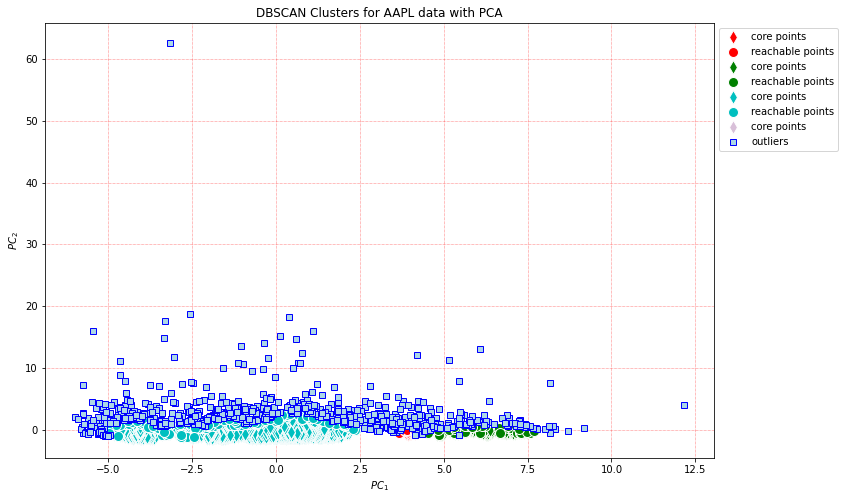

In [ ]:
aapl.getPCA()
aapl.pcaNewData = aapl.pcaNewData[:,:2]
aapl_pca_db = DBSCAN(eps=0.3, min_samples =20).fit(aapl.pcaNewData)
plotDB(aapl_pca_db,aapl.pcaNewData, 'AAPL', 'PCA')

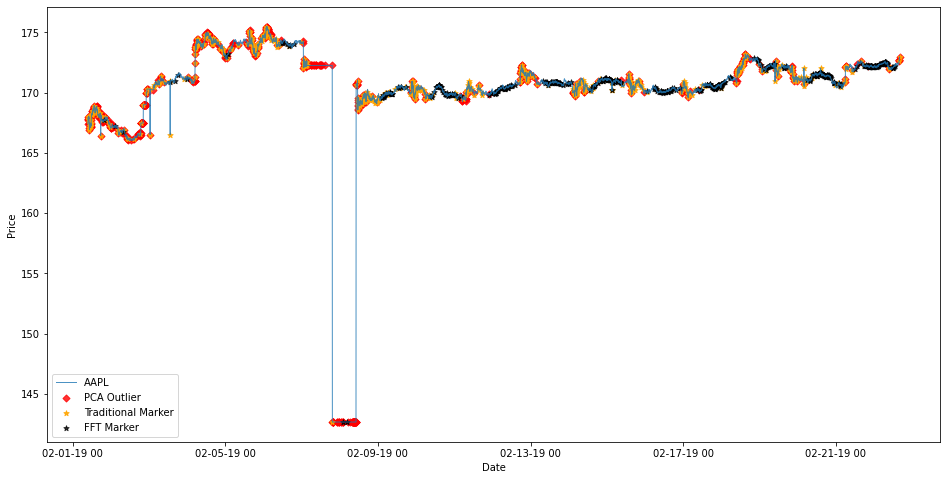

In [ ]:
aapl_pca_markers = (aapl_pca_db.labels_==-1)
plotMarkers(aapl_df, 'AAPL', 'PCA',aapl_pca_markers, aapl.global_mask(), aapl.fft_mask())

In [ ]:
aapl_truemarker = aapl.fftRanking.index  | aapl_df[aapl_df['Marker'] == True].index
calcuMse1(aapl_df, dateToNumeric(aapl_df,aapl_df['marketClose'][aapl_pca_markers].index), 
          dateToNumeric(aapl_df, aapl_truemarker))
calCoverageRate(aapl_df['marketClose'][aapl_pca_markers].index,aapl_truemarker)

MSE:  40.671073623919256
Coverage Rate:  0.41786743515850144


### TSNE Analysis

32  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, -1}
outliers:  232


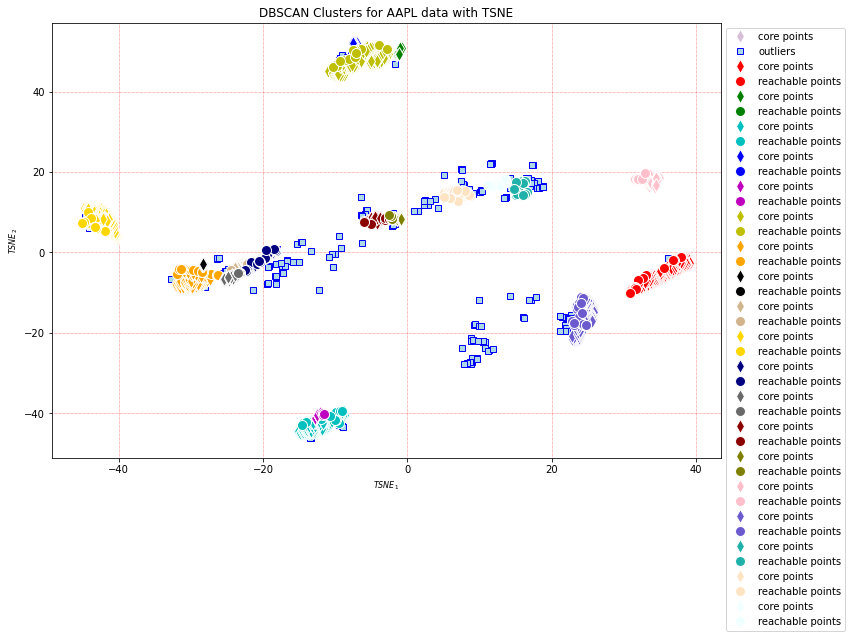

In [ ]:
aapl.getTSNE(200, 'pca')
aapl.tsneNewData = aapl.tsneNewData[:,:2]
aapl_tsne_db = DBSCAN(eps=0.8, min_samples =12).fit(aapl.tsneNewData)
plotDB(aapl_tsne_db,aapl.tsneNewData, 'AAPL', 'TSNE')

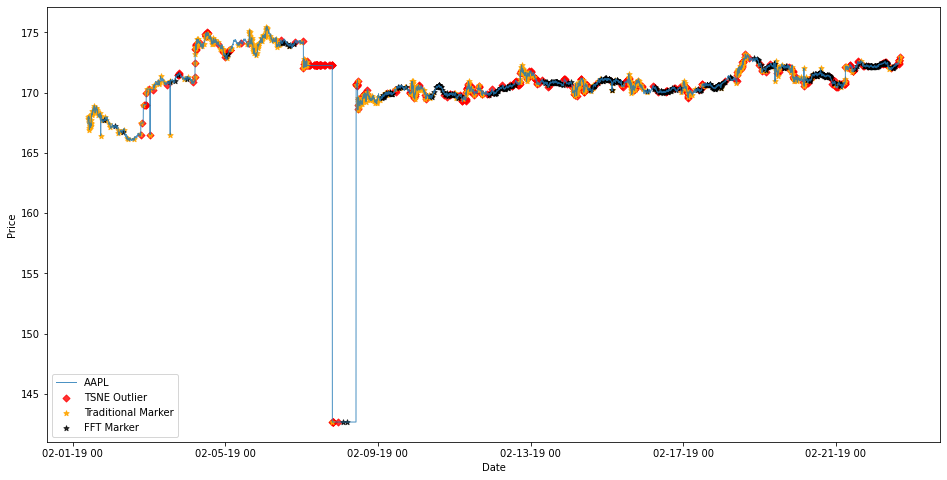

In [ ]:
aapl_tsne_markers = (aapl_tsne_db.labels_==-1)
plotMarkers(aapl_df, 'AAPL', 'TSNE',aapl_tsne_markers, aapl.global_mask(), aapl.fft_mask())

In [ ]:
calcuMse1(aapl_df, dateToNumeric(aapl_df,aapl_df['marketClose'][aapl_tsne_markers].index), 
          dateToNumeric(aapl_df, aapl_truemarker))
calCoverageRate(aapl_df['marketClose'][aapl_tsne_markers].index,aapl_truemarker)

MSE:  31.052095731249935
Coverage Rate:  0.07708333333333334


### UMAP Analysis

27  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -1}
outliers:  38


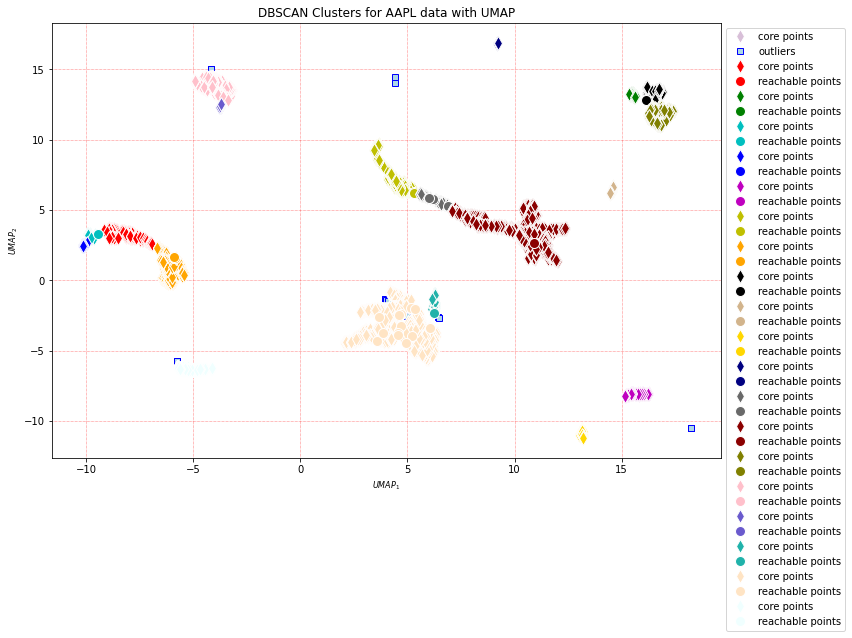

In [ ]:
aapl.getUMAP(10, 0.3)
aapl.umapNewData = aapl.umapNewData[:,:2]
aapl_umap_db = DBSCAN(eps=0.3, min_samples =10).fit(aapl.umapNewData)
plotDB(aapl_umap_db,aapl.umapNewData, 'AAPL', 'UMAP')

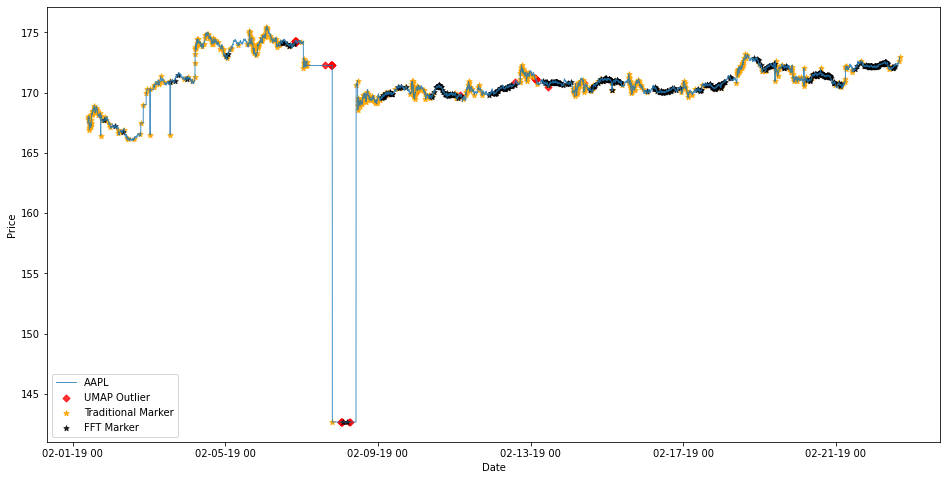

In [ ]:
aapl_umap_markers = (aapl_umap_db.labels_==-1)
plotMarkers(aapl_df, 'AAPL', 'UMAP',aapl_umap_markers, aapl.global_mask(), aapl.fft_mask())

In [ ]:
calcuMse1(aapl_df, dateToNumeric(aapl_df,aapl_df[aapl_umap_markers].index), 
          dateToNumeric(aapl_df, aapl_truemarker))
calCoverageRate(aapl_df[aapl_umap_markers].index,aapl_truemarker)

MSE:  184.15059307894708
Coverage Rate:  0.0


### LLE Analysis

10  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
outliers:  611


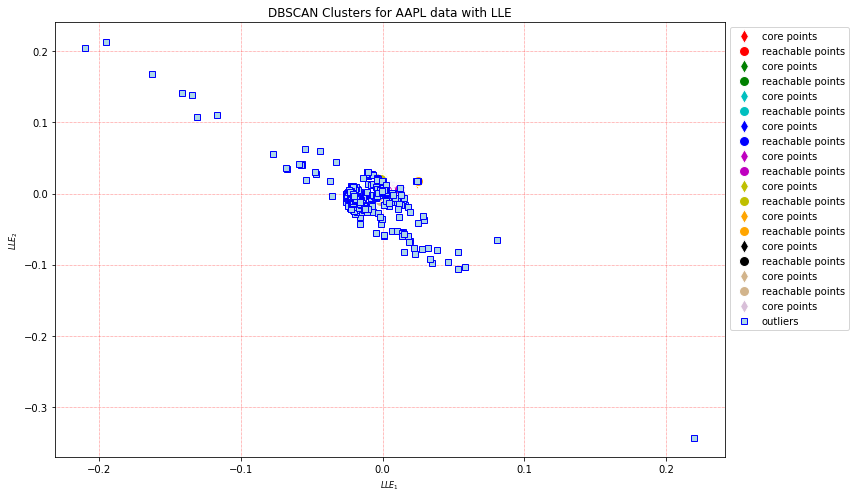

In [ ]:
aapl.getLLE(100)
aapl.lleNewData = aapl.lleNewData[:,:2]
aapl_lle_db = DBSCAN(eps=0.001, min_samples =20).fit(aapl.lleNewData)
plotDB(aapl_lle_db,aapl.lleNewData, 'AAPL', 'LLE')

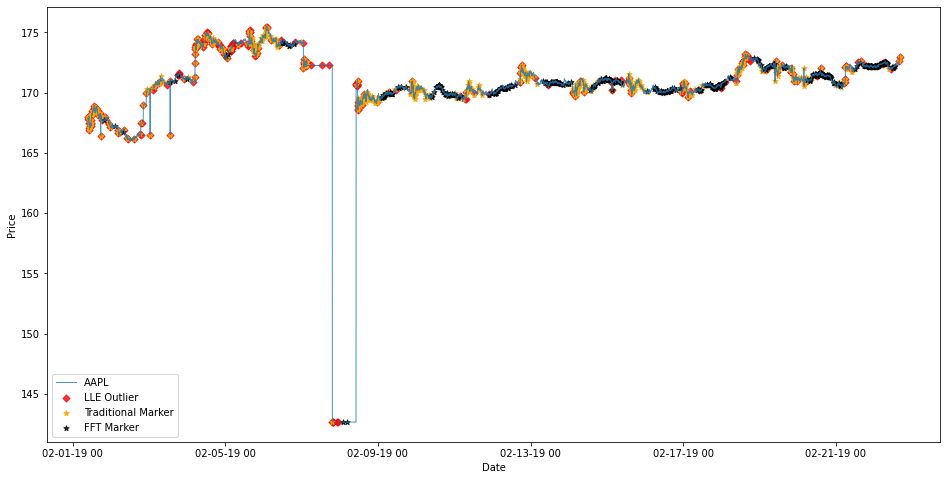

In [ ]:
aapl_lle_markers = (aapl_lle_db.labels_==-1)
plotMarkers(aapl_df, 'AAPL', 'LLE',aapl_lle_markers, aapl.global_mask(), aapl.fft_mask())

In [ ]:

calcuMse1(aapl_df, dateToNumeric(aapl_df,aapl_df[aapl_lle_markers].index), 
          dateToNumeric(aapl_df,aapl_truemarker))
calCoverageRate(aapl_df[aapl_lle_markers].index,aapl_truemarker)

MSE:  5.519383786833848
Coverage Rate:  0.5830721003134797


## AEO

In [ ]:
aeo = dimension_reduction('AEO',aeo_df)
aeo.fft_trans()

### PCA Analysis

3  labels:  {0, 1, -1}
outliers:  746


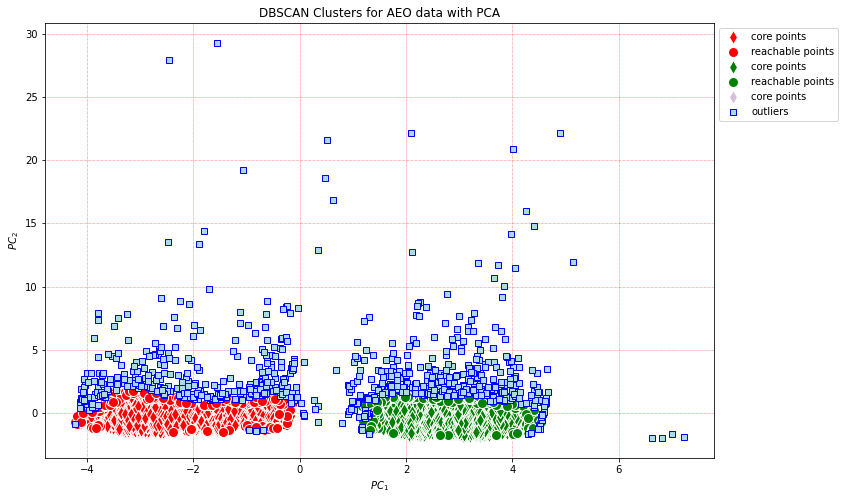

In [ ]:
aeo.getPCA()
aeo.pcaNewData = aeo.pcaNewData[:,:2]
aeo_pca_db = DBSCAN(eps=0.3, min_samples =30).fit(aeo.pcaNewData)
plotDB(aeo_pca_db,aeo.pcaNewData, 'AEO', 'PCA')

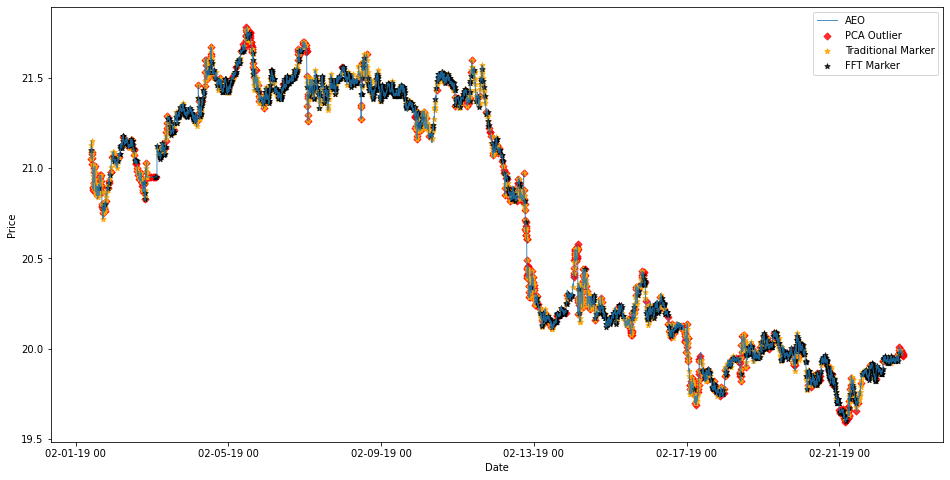

In [ ]:
aeo_pca_markers = (aeo_pca_db.labels_==-1)
plotMarkers(aeo_df, 'AEO', 'PCA',aeo_pca_markers, aeo.global_mask(), aeo.fft_mask())

In [ ]:
aeo_truemarker = aeo.fftRanking.index|aeo_df[aeo_df['Marker'] == True].index
calcuMse1(aeo_df, dateToNumeric(aeo_df,aeo_df[aeo_pca_markers].index), 
          dateToNumeric(aeo_df, aeo_truemarker))
calCoverageRate(aeo_df[aeo_pca_markers].index,aeo_truemarker)

MSE:  0.00056405764075067
Coverage Rate:  0.5281501340482574


### TSNE Analysis

17  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}
outliers:  378


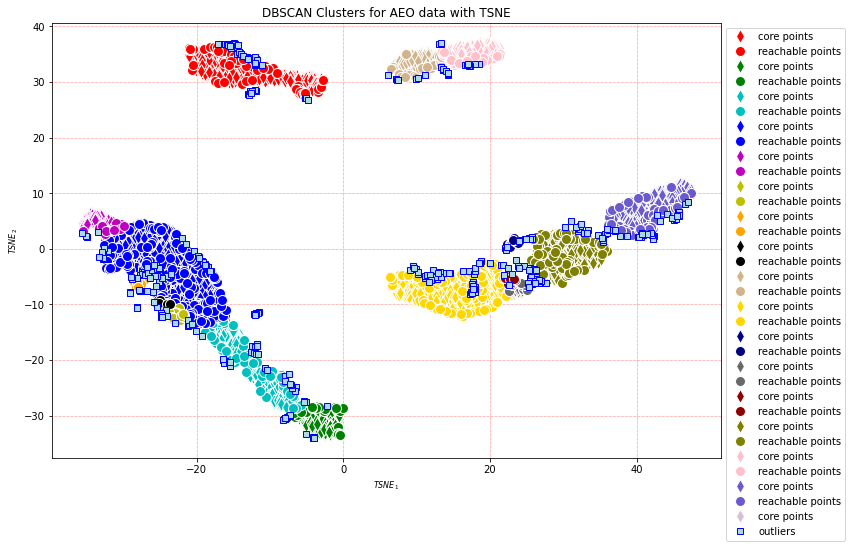

In [ ]:
aeo.getTSNE(200, 'pca')
aeo.tsneNewData = aeo.tsneNewData[:,:2]
aeo_tsne_db = DBSCAN(eps=1, min_samples =20).fit(aeo.tsneNewData)
plotDB(aeo_tsne_db,aeo.tsneNewData, 'AEO', 'TSNE')

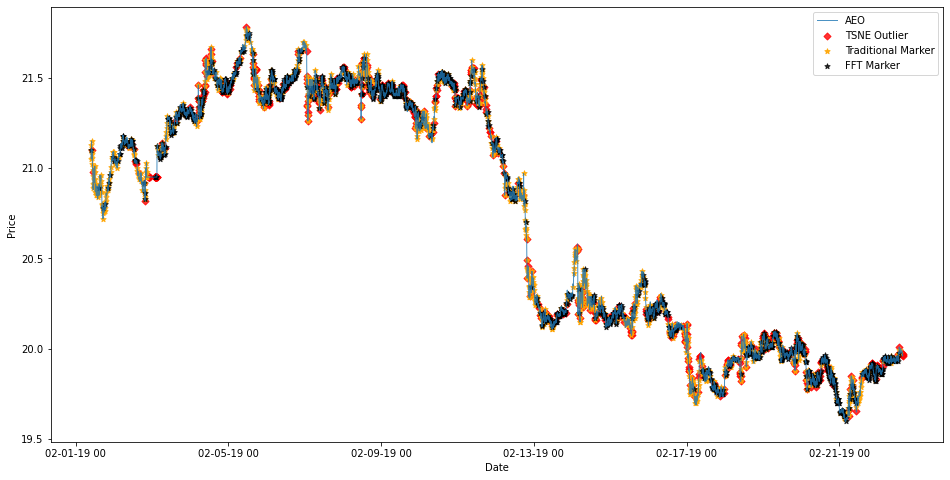

In [ ]:
aeo_tsne_markers = (aeo_tsne_db.labels_==-1)
plotMarkers(aeo_df, 'AEO', 'TSNE',aeo_tsne_markers, aeo.global_mask(), aeo.fft_mask())

In [ ]:
calcuMse1(aeo_df, dateToNumeric(aeo_df,aeo_df[aeo_tsne_markers].index), 
          dateToNumeric(aeo_df, aeo_truemarker))
calCoverageRate(aeo_df[aeo_tsne_markers].index,aeo_truemarker)

MSE:  0.0004633470967741923
Coverage Rate:  0.26838709677419353


### UMAP Analysis

14  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
outliers:  35


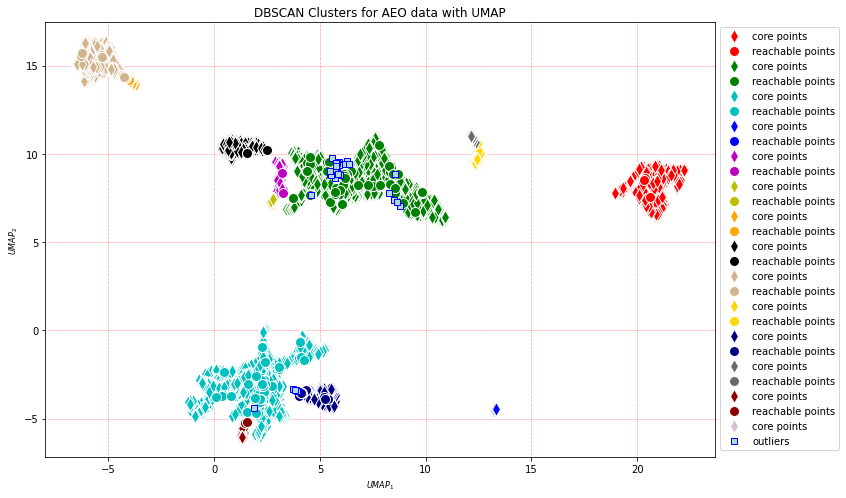

In [ ]:
aeo.getUMAP(20 , 0.1)
aeo.umapNewData = aeo.umapNewData[:,:2]
aeo_umap_db = DBSCAN(eps=0.3, min_samples =15).fit(aeo.umapNewData)
plotDB(aeo_umap_db,aeo.umapNewData, 'AEO', 'UMAP')

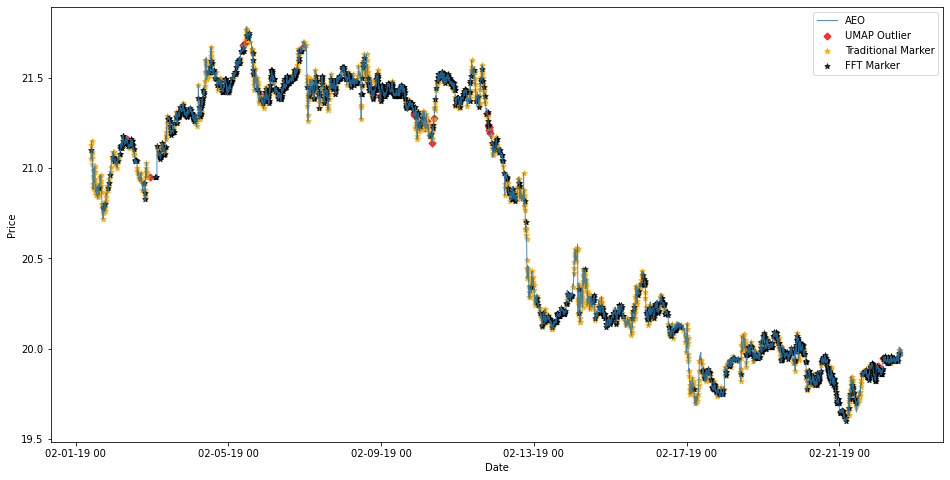

In [ ]:
aeo_umap_markers = (aeo_umap_db.labels_==-1)
plotMarkers(aeo_df, 'AEO', 'UMAP',aeo_umap_markers, aeo.global_mask(), aeo.fft_mask())

In [ ]:
calcuMse1(aeo_df, dateToNumeric(aeo_df,aeo_df[aeo_umap_markers].index), 
          dateToNumeric(aeo_df, aeo_truemarker))
calCoverageRate(aeo_df[aeo_umap_markers].index,aeo_truemarker)

MSE:  0.000238171428571423
Coverage Rate:  0.02857142857142857


### LLE Analysis

4  labels:  {0, 1, 2, -1}
outliers:  261


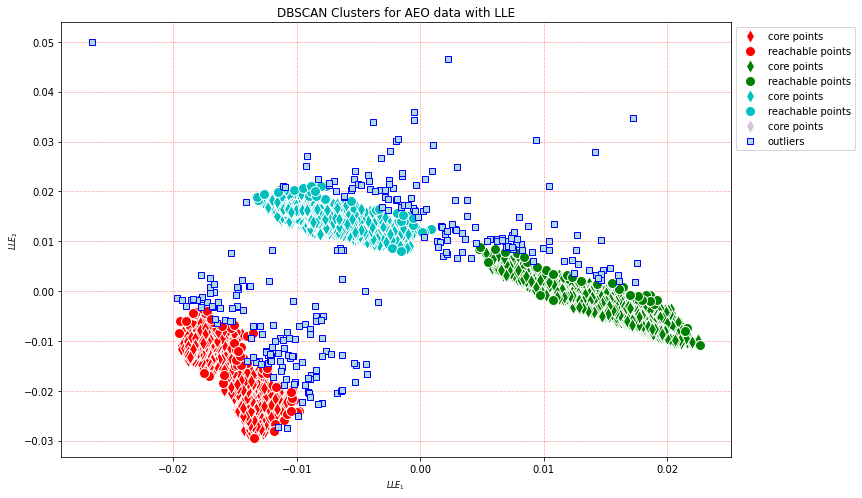

In [ ]:
aeo.getLLE(100)
aeo.lleNewData = aeo.lleNewData[:,:2]
aeo_lle_db = DBSCAN(eps=0.001, min_samples =10).fit(aeo.lleNewData)
plotDB(aeo_lle_db, aeo.lleNewData, 'AEO', 'LLE')

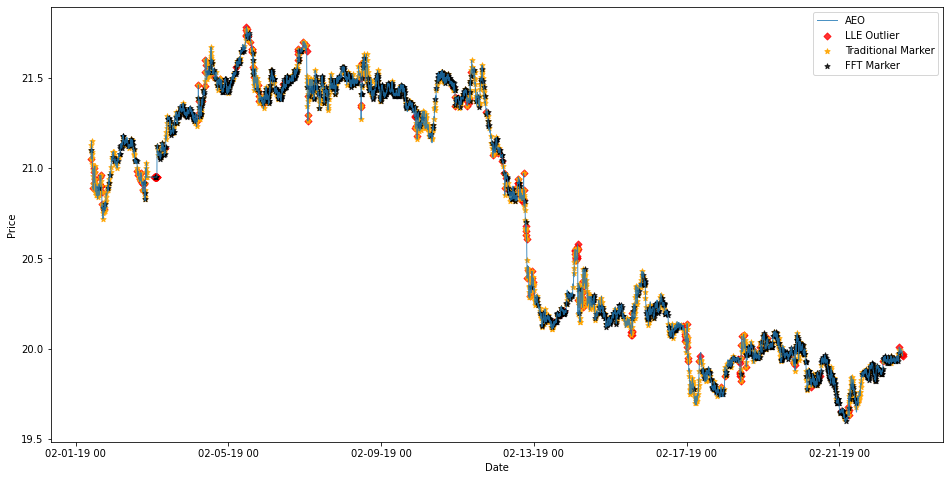

In [ ]:
aeo_lle_markers = (aeo_lle_db.labels_==-1)
plotMarkers(aeo_df, 'AEO', 'LLE',aeo_lle_markers, aeo.global_mask(), aeo.fft_mask())

In [ ]:
calcuMse1(aeo_df, dateToNumeric(aeo_df,aeo_df[aeo_lle_markers].index), 
          dateToNumeric(aeo_df, aeo_truemarker))
calCoverageRate(aeo_df[aeo_lle_markers].index,aeo_truemarker)

MSE:  0.0007409348659003838
Coverage Rate:  0.5172413793103449


## BAC

In [ ]:
bac = dimension_reduction('BAC',bac_df)
bac.fft_trans()

### PCA Analysis

2  labels:  {0, -1}
outliers:  448


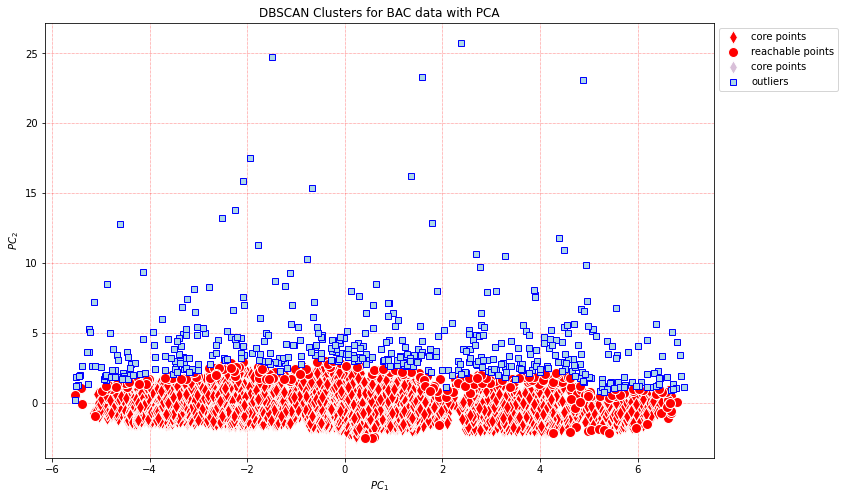

In [ ]:
bac.getPCA()
bac.pcaNewData = bac.pcaNewData[:,:2]
bac_pca_db = DBSCAN(eps=0.5, min_samples =30).fit(bac.pcaNewData)
plotDB(bac_pca_db,bac.pcaNewData, 'BAC', 'PCA')

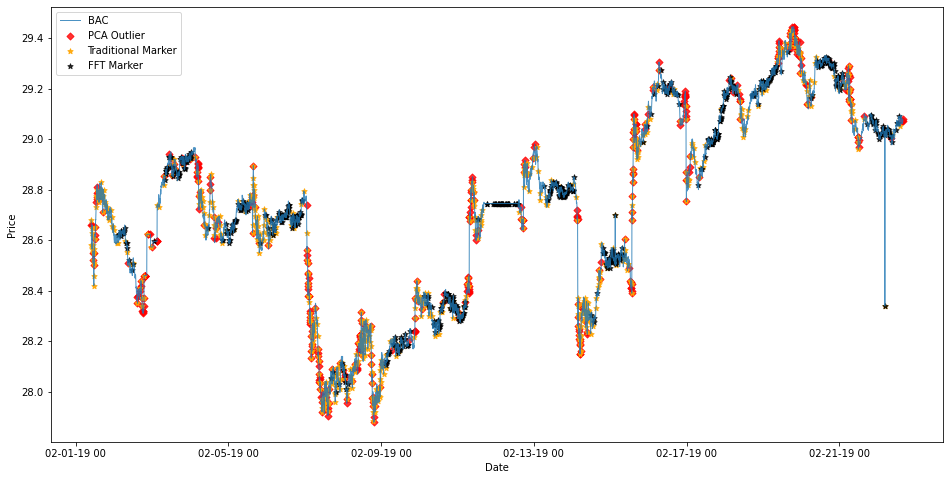

In [ ]:
bac_pca_markers = (bac_pca_db.labels_==-1)
plotMarkers(bac_df, 'BAC', 'PCA',bac_pca_markers, bac.global_mask(), bac.fft_mask())

In [ ]:
bac_truemarker =  bac.fftRanking.index | bac_df[bac_df['Marker'] == True].index
calcuMse1(bac_df, dateToNumeric(bac_df,bac_df[bac_pca_markers].index), 
          dateToNumeric(bac_df, bac_truemarker))
calCoverageRate(bac_df[bac_pca_markers].index,bac_truemarker)

MSE:  0.001397185267857148
Coverage Rate:  0.46875


### TSNE Analysis

20  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1}
outliers:  182


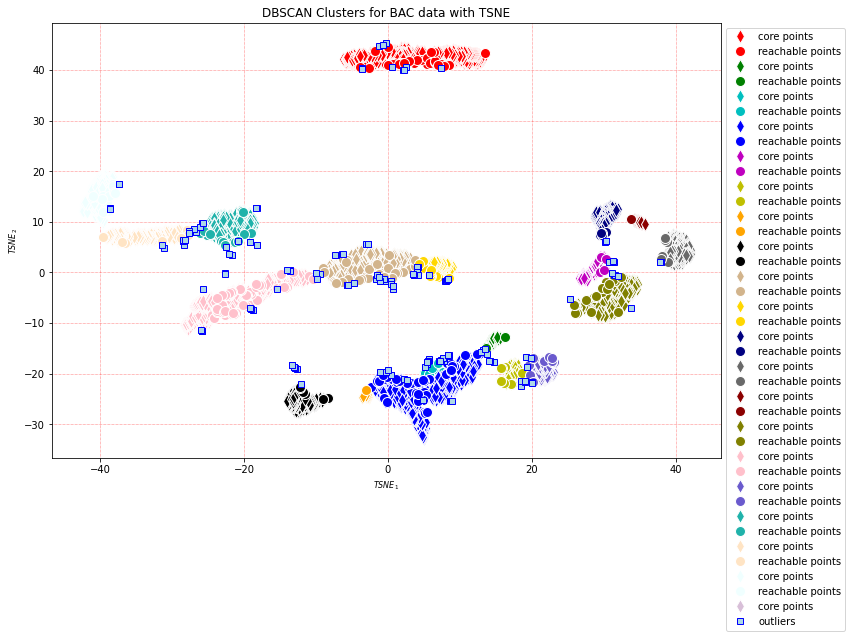

In [ ]:
bac.getTSNE(200, 'pca')
bac.tsneNewData = bac.tsneNewData[:,:2]
bac_tsne_db = DBSCAN(eps=1, min_samples =15).fit(bac.tsneNewData)
plotDB(bac_tsne_db,bac.tsneNewData, 'BAC', 'TSNE')

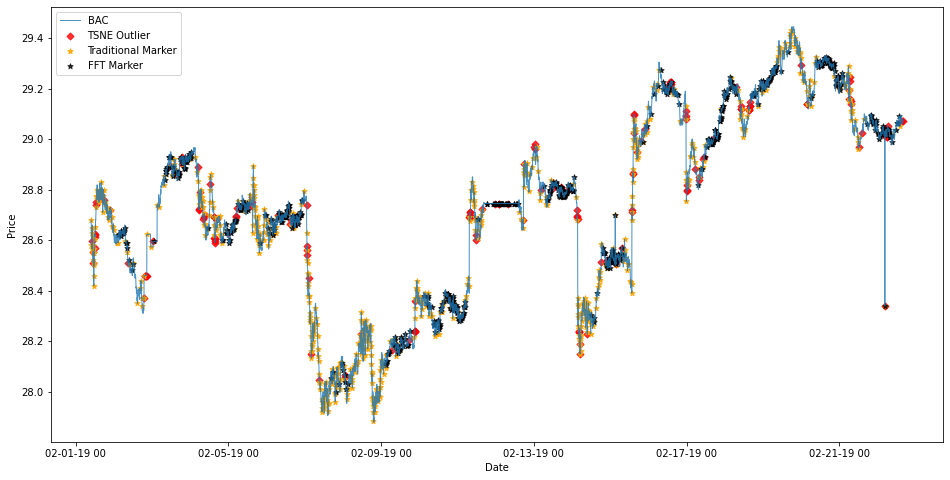

In [ ]:
bac_tsne_markers = (bac_tsne_db.labels_==-1)
plotMarkers(bac_df, 'BAC', 'TSNE',bac_tsne_markers, bac.global_mask(), bac.fft_mask())


In [ ]:
calcuMse1(bac_df, dateToNumeric(bac_df,bac_df[bac_tsne_markers].index), 
          dateToNumeric(bac_df, bac_truemarker))
calCoverageRate(bac_df[bac_tsne_markers].index,bac_truemarker)

MSE:  0.0019910329670329674
Coverage Rate:  0.11538461538461539


### UMAP Analysis

29  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, -1}
outliers:  86


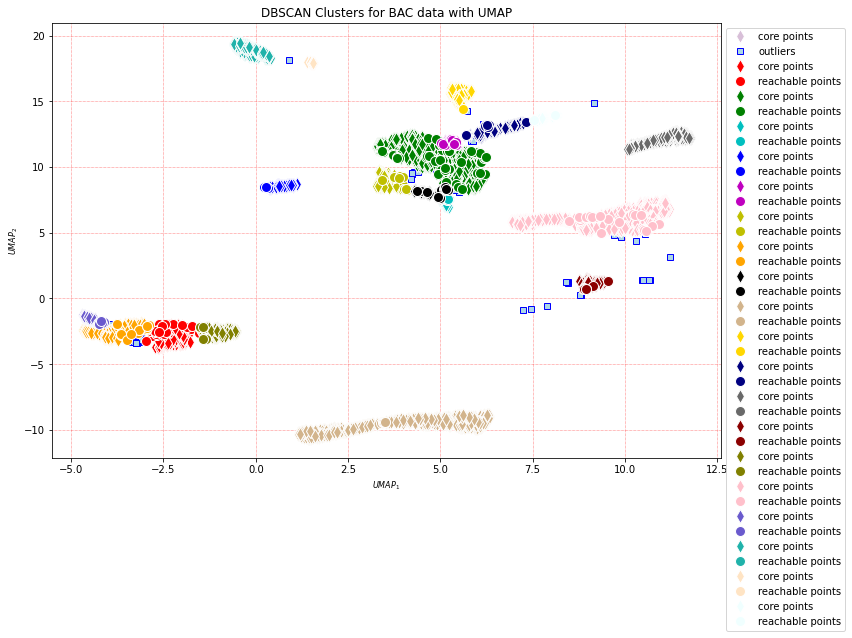

In [ ]:
bac.getUMAP(10 , 0.1)
bac.umapNewData = bac.umapNewData[:,:2]
bac_umap_db = DBSCAN(eps=0.3, min_samples =20).fit(bac.umapNewData)
plotDB(bac_umap_db,bac.umapNewData, 'BAC', 'UMAP')

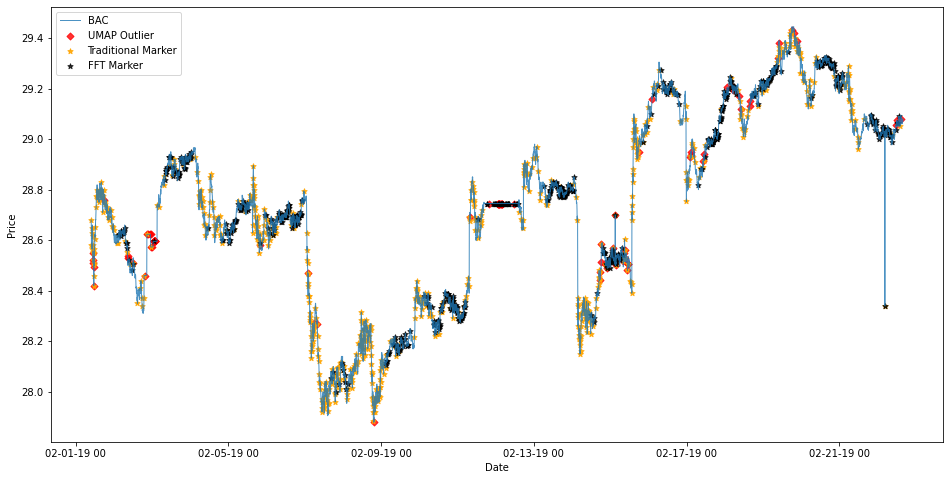

In [ ]:
bac_umap_markers = (bac_umap_db.labels_==-1)
plotMarkers(bac_df, 'BAC', 'UMAP',bac_umap_markers, bac.global_mask(), bac.fft_mask())


In [ ]:
calcuMse1(bac_df, dateToNumeric(bac_df,bac_df[bac_umap_markers].index), 
          dateToNumeric(bac_df, bac_truemarker))
calCoverageRate(bac_df[bac_umap_markers].index,bac_truemarker)

MSE:  0.00032905813953488556
Coverage Rate:  0.38372093023255816


### LLE Analysis

3  labels:  {0, 1, -1}
outliers:  134


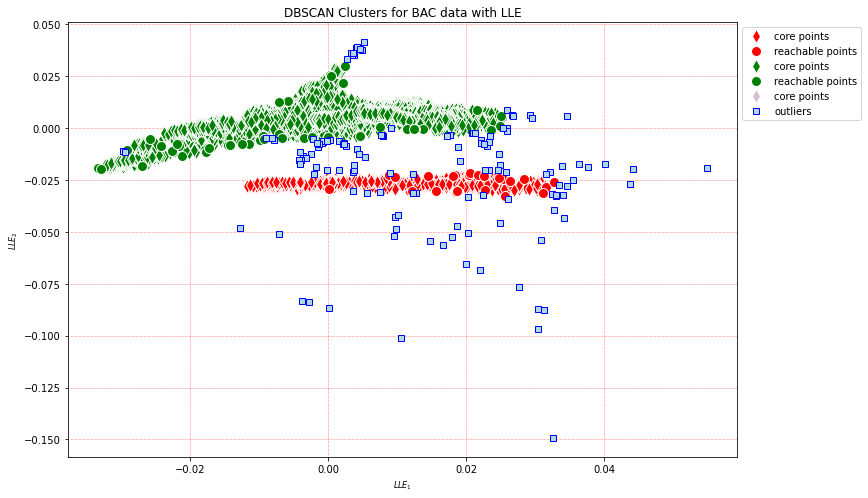

In [ ]:
bac.getLLE(100)
bac.lleNewData = bac.lleNewData[:,:2]
bac_lle_db = DBSCAN(eps=0.002, min_samples =10).fit(bac.lleNewData)
plotDB(bac_lle_db, bac.lleNewData, 'BAC', 'LLE')

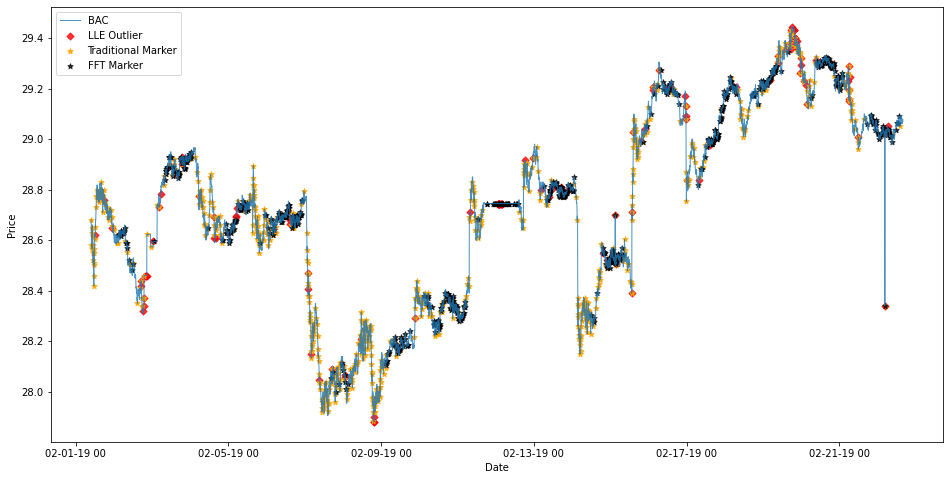

In [ ]:
bac_lle_markers = (bac_lle_db.labels_==-1)
plotMarkers(bac_df, 'BAC', 'LLE',bac_lle_markers, bac.global_mask(), bac.fft_mask())


In [ ]:
calcuMse1(bac_df, dateToNumeric(bac_df,bac_df[bac_lle_markers].index), 
          dateToNumeric(bac_df, bac_truemarker))
calCoverageRate(bac_df[bac_lle_markers].index,bac_truemarker)

MSE:  0.0008934029850746202
Coverage Rate:  0.3656716417910448


## WMT

In [ ]:
wmt = dimension_reduction('WMT',wmt_df)
wmt.fft_trans()

### PCA

5  labels:  {0, 1, 2, 3, -1}
outliers:  246


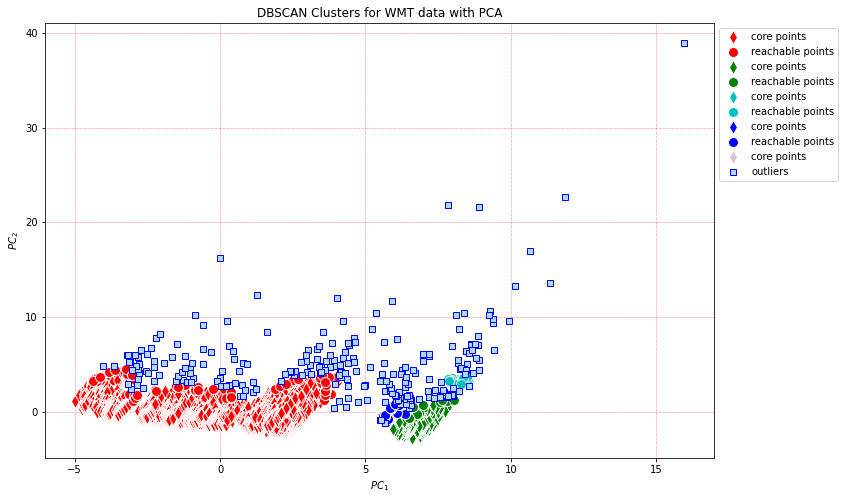

In [ ]:
wmt.getPCA()
wmt.pcaNewData = wmt.pcaNewData[:,:2]
wmt_pca_db = DBSCAN(eps=0.5, min_samples =15).fit(wmt.pcaNewData)
plotDB(wmt_pca_db,wmt.pcaNewData, 'WMT', 'PCA')

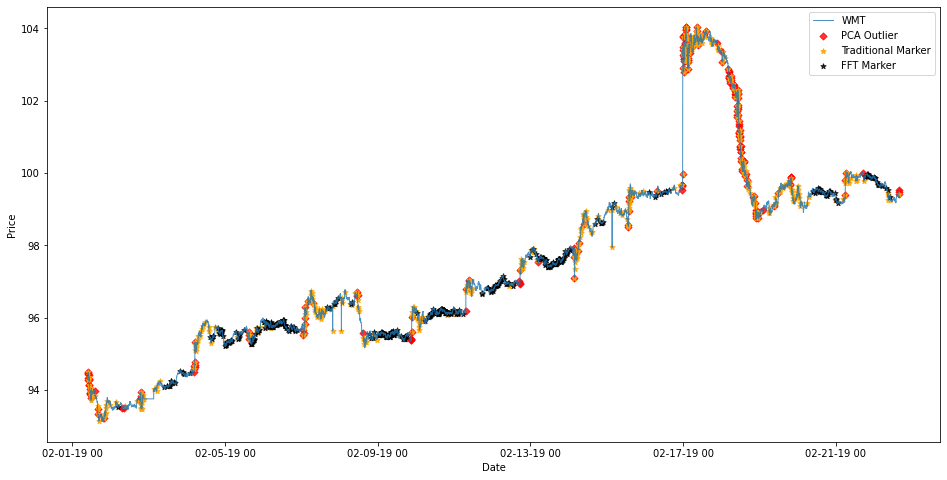

In [ ]:
wmt_pca_markers = (wmt_pca_db.labels_==-1)
plotMarkers(wmt_df, 'WMT', 'PCA',wmt_pca_markers, wmt.global_mask(), wmt.fft_mask())


In [ ]:
wmt_truemarker =  wmt.fftRanking.index | wmt_df[wmt_df['Marker'] == True].index
calcuMse1(wmt_df, dateToNumeric(wmt_df,wmt_df[wmt_pca_markers].index), 
          dateToNumeric(wmt_df,wmt_truemarker))
calCoverageRate(wmt_df[wmt_pca_markers].index,wmt_truemarker)

MSE:  0.008879711382113938
Coverage Rate:  0.573170731707317


### TSNE

19  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1}
outliers:  189


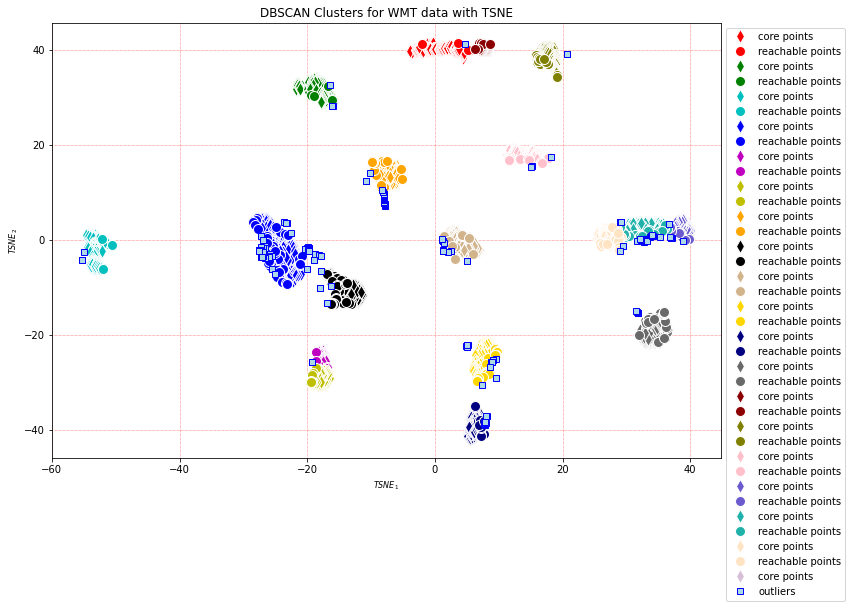

In [ ]:
wmt.getTSNE(200, 'pca')
wmt.tsneNewData = wmt.tsneNewData[:,:2]
wmt_tsne_db = DBSCAN(eps=0.9, min_samples =20).fit(wmt.tsneNewData)
plotDB(wmt_tsne_db,wmt.tsneNewData, 'WMT', 'TSNE')

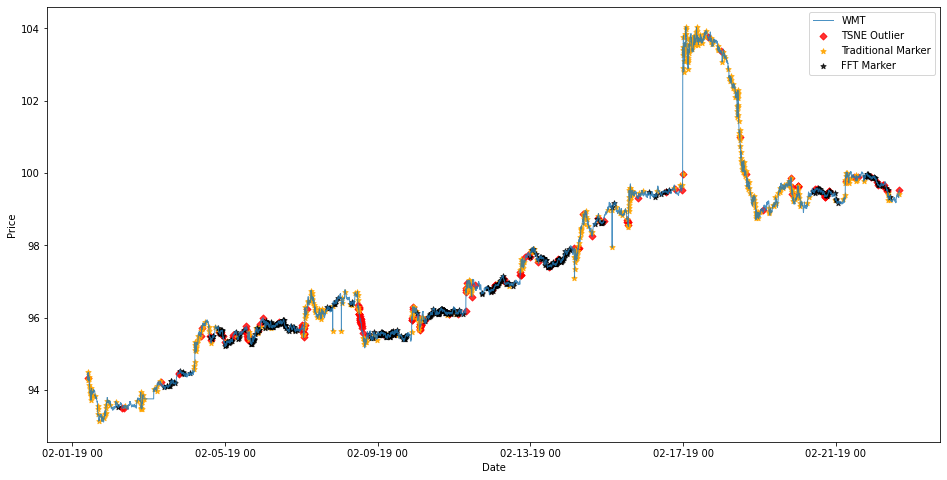

In [ ]:
wmt_tsne_markers = (wmt_tsne_db.labels_==-1)
plotMarkers(wmt_df, 'WMT', 'TSNE',wmt_tsne_markers, wmt.global_mask(), wmt.fft_mask())


In [ ]:
calcuMse1(wmt_df, dateToNumeric(wmt_df,wmt_df[wmt_tsne_markers].index), 
          dateToNumeric(wmt_df, wmt_truemarker))
calCoverageRate(wmt_df[wmt_tsne_markers].index, wmt_truemarker)

MSE:  0.01706495238095272
Coverage Rate:  0.031746031746031744


### UMAP

25  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, -1}
outliers:  113


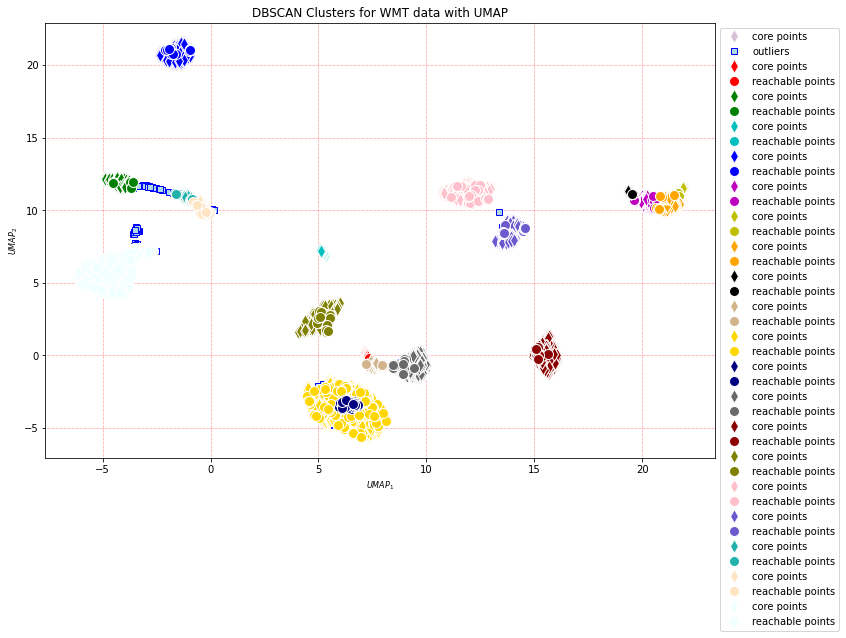

In [ ]:
wmt.getUMAP(50 , 0.1)
wmt.umapNewData = wmt.umapNewData[:,:2]
wmt_umap_db = DBSCAN(eps=0.3, min_samples =25).fit(wmt.umapNewData)
plotDB(wmt_umap_db,wmt.umapNewData, 'WMT', 'UMAP')

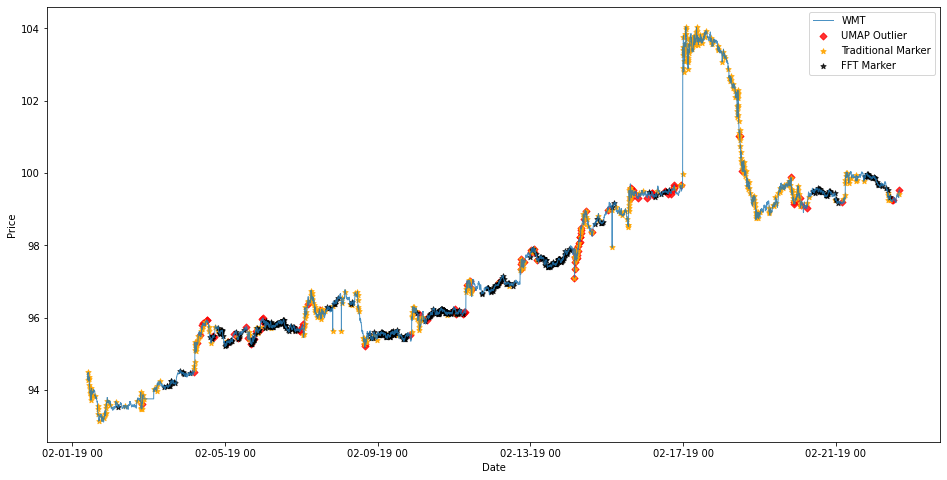

In [ ]:
wmt_umap_markers = (wmt_umap_db.labels_==-1)
plotMarkers(wmt_df, 'WMT', 'UMAP',wmt_umap_markers, wmt.global_mask(), wmt.fft_mask())


In [ ]:
calcuMse1(wmt_df, dateToNumeric(wmt_df,wmt_df[wmt_umap_markers].index), 
          dateToNumeric(wmt_df, wmt_truemarker))
calCoverageRate(wmt_df[wmt_umap_markers].index,wmt_truemarker)

MSE:  0.009168743362831978
Coverage Rate:  0.35398230088495575


### LLE

4  labels:  {0, 1, 2, -1}
outliers:  100


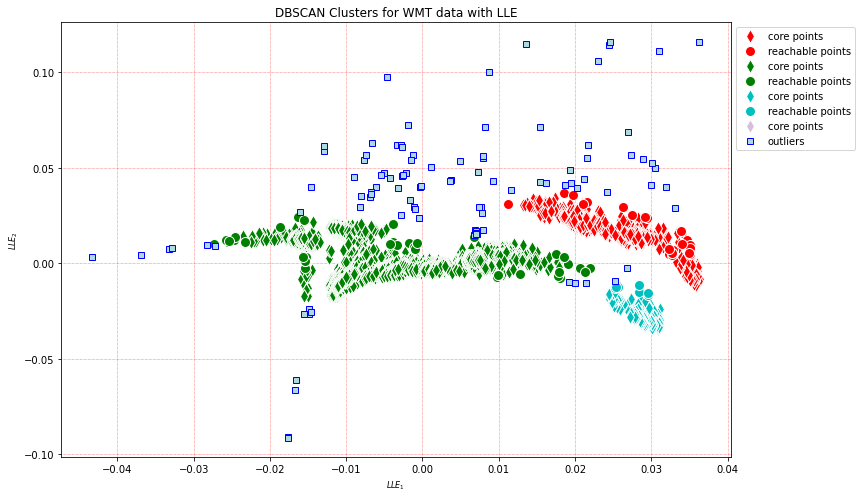

In [ ]:
wmt.getLLE(100)
wmt.lleNewData = wmt.lleNewData[:,:2]
wmt_lle_db = DBSCAN(eps=0.005, min_samples =25).fit(wmt.lleNewData)
plotDB(wmt_lle_db, wmt.lleNewData, 'WMT', 'LLE')

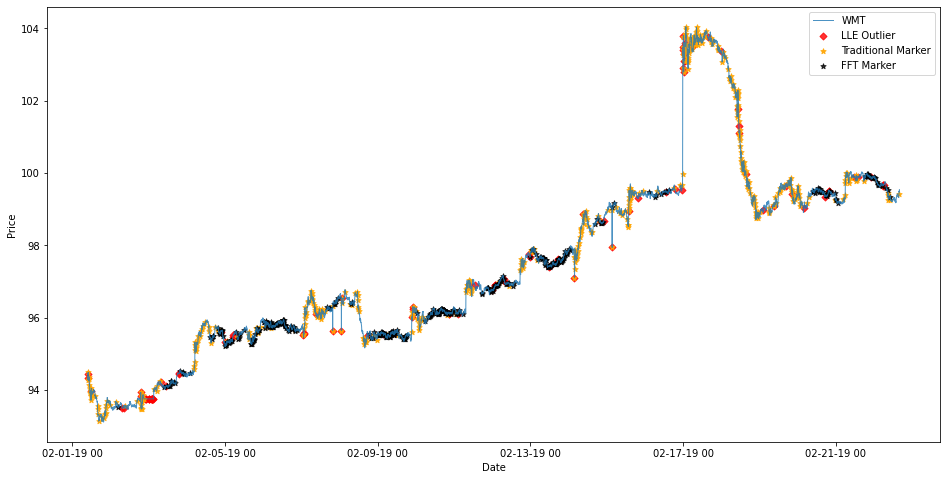

In [ ]:
wmt_lle_markers = (wmt_lle_db.labels_==-1)
plotMarkers(wmt_df, 'WMT', 'LLE',wmt_lle_markers, wmt.global_mask(), wmt.fft_mask())


In [ ]:
calcuMse1(wmt_df, dateToNumeric(wmt_df,wmt_df[wmt_lle_markers].index), 
          dateToNumeric(wmt_df, wmt_truemarker))
calCoverageRate(wmt_df[wmt_lle_markers].index,wmt_truemarker)

MSE:  0.011554859999999945
Coverage Rate:  0.23


# OWN data

In [ ]:
!pip install yfinance -U -q

     |████████████████████████████████| 5.5MB 3.9MB/s 


In [ ]:
import yfinance as yf

In [ ]:
tickerSymbol = 'GOOG'
tickerData = yf.Ticker(tickerSymbol)
start_time="2020-10-20"
end_time="2020-10-27"
goog_df = tickerData.history(tickers = tickerSymbol, interval = "1m",
start=start_time, end=end_time)
goog_df.head()

Open         High  ...  Dividends  Stock Splits
Datetime                                             ...                         
2020-10-20 09:30:00-04:00  1527.050049  1533.000000  ...          0             0
2020-10-20 09:31:00-04:00  1532.400024  1533.125000  ...          0             0
2020-10-20 09:32:00-04:00  1529.540039  1538.760010  ...          0             0
2020-10-20 09:33:00-04:00  1539.986694  1542.119995  ...          0             0
2020-10-20 09:34:00-04:00  1540.461548  1540.461548  ...          0             0

[5 rows x 7 columns]

In [ ]:
tickerSymbol = 'INTC'
tickerData = yf.Ticker(tickerSymbol)
start_time="2020-10-20"
end_time="2020-10-27"
intel_df = tickerData.history(tickers = tickerSymbol, interval = "1m",
start=start_time, end=end_time)
intel_df.head()

Open       High  ...  Dividends  Stock Splits
Datetime                                         ...                         
2020-10-20 09:30:00-04:00  54.599998  54.700001  ...          0             0
2020-10-20 09:31:00-04:00  54.570000  54.619999  ...          0             0
2020-10-20 09:32:00-04:00  54.360001  54.360001  ...          0             0
2020-10-20 09:33:00-04:00  54.255001  54.349998  ...          0             0
2020-10-20 09:34:00-04:00  54.189999  54.250000  ...          0             0

[5 rows x 7 columns]

In [ ]:
HFT = [goog_df, intel_df]
for item in HFT:
    item['marketClose'] = item['Close']
    item['marketHigh'] = item['High']
    item['marketLow'] = item['Low']
    item['marketOpen'] = item['Open']
    item['closeOfHigh'] = (item['marketHigh']-item['marketClose'])/(item['marketHigh'] - item['marketLow'])
    item['pseudoVolatility'] = (item['marketHigh']-item['marketLow'])/item['marketOpen']
    item['TypicalPrice'] = (item['marketHigh']+item['marketLow']+item['marketClose'])/3
    item['10DayMA'] = item['TypicalPrice'].rolling(window=10).mean()
    item['10DaySTD'] = item['TypicalPrice'].rolling(window=10).std()  
    item['UpperBand'] = item['10DayMA'] + (item['10DaySTD'] * 2)
    item['LowerBand'] = item['10DayMA'] - (item['10DaySTD'] * 2)
    item['Marker'] = abs(item['marketClose']/item['marketClose'].shift(1)-1)>= 0.0005




In [ ]:
goog_df = goog_df.drop(columns=['TypicalPrice', '10DaySTD', 'High', 'Low', 'Close', 'Open','Dividends', 'Stock Splits'])
intel_df = intel_df.drop(columns=['TypicalPrice', '10DaySTD',  'High', 'Low', 'Close', 'Open','Dividends', 'Stock Splits'])
goog_df = goog_df.iloc[9:,:]
intel_df = intel_df.iloc[9:,:]


In [ ]:
goog_df=goog_df.fillna('0')
goog_df.dropna(inplace=True)
intel_df=intel_df.fillna('0')
intel_df.dropna(inplace=True)
intel_df.head()

Volume  marketClose  ...  LowerBand  Marker
Datetime                                        ...                   
2020-10-20 09:39:00-04:00  133482    53.971802  ...  53.885392    True
2020-10-20 09:40:00-04:00   98040    54.073399  ...  53.934335    True
2020-10-20 09:41:00-04:00   63193    54.130001  ...  53.978371    True
2020-10-20 09:42:00-04:00  133556    54.215000  ...  53.981129    True
2020-10-20 09:43:00-04:00   76466    54.165001  ...  53.986353    True

[5 rows x 11 columns]

In [ ]:
print(aapl_df['Marker'][aapl_df['Marker']==True])
print(aeo_df['Marker'][aeo_df['Marker']==True])

Date
2019-02-01 09:40:00    True
2019-02-01 09:41:00    True
2019-02-01 09:45:00    True
2019-02-01 09:46:00    True
2019-02-01 09:48:00    True
                       ... 
2019-02-22 13:17:00    True
2019-02-22 14:35:00    True
2019-02-22 14:40:00    True
2019-02-22 15:55:00    True
2019-02-22 15:59:00    True
Name: Marker, Length: 521, dtype: bool
Date
2019-02-01 09:39:00    True
2019-02-01 09:40:00    True
2019-02-01 09:41:00    True
2019-02-01 09:42:00    True
2019-02-01 09:43:00    True
                       ... 
2019-02-22 15:11:00    True
2019-02-22 15:28:00    True
2019-02-22 15:32:00    True
2019-02-22 15:36:00    True
2019-02-22 15:40:00    True
Name: Marker, Length: 1404, dtype: bool


# GOOG

In [ ]:
goog = dimension_reduction('goog',goog_df)
goog.fft_trans()

4  labels:  {0, 1, 2, -1}
outliers:  191


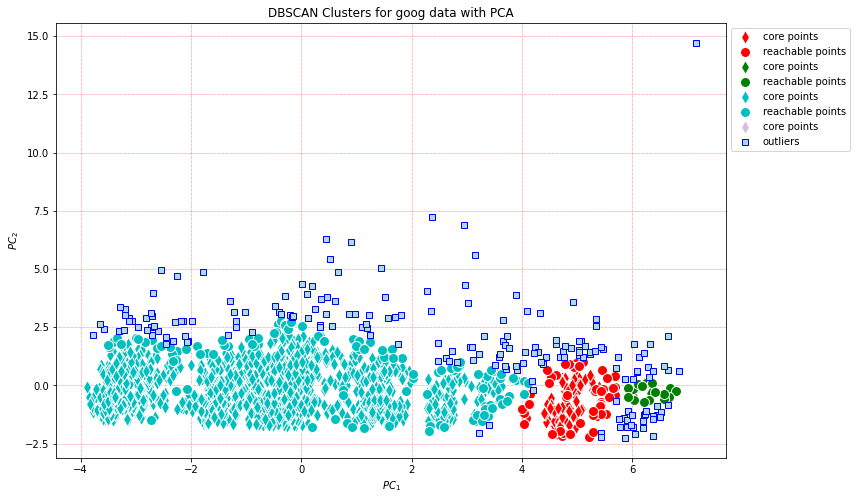

In [ ]:
goog.getPCA()
goog.pcaNewData = goog.pcaNewData[:,:2]
goog_pca_db = DBSCAN(eps=0.5, min_samples =20).fit(goog.pcaNewData)
plotDB(goog_pca_db,goog.pcaNewData, 'goog', 'PCA')

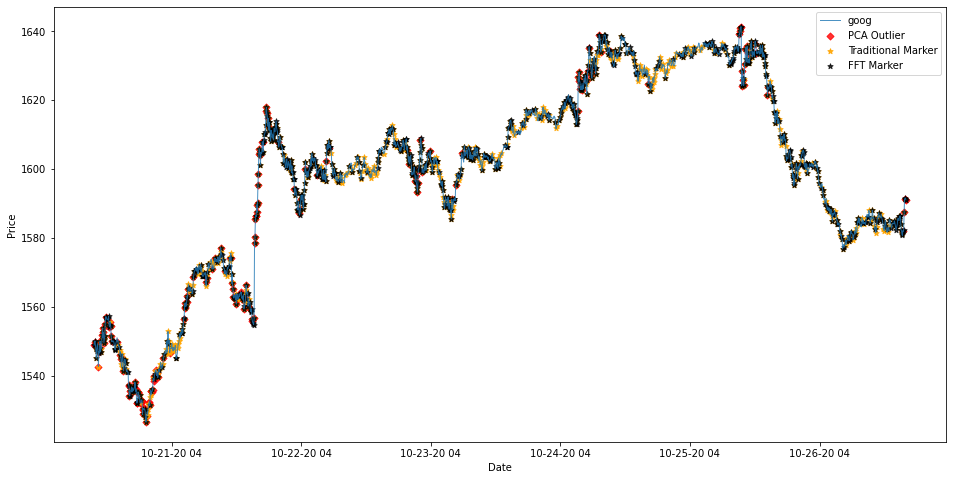

In [ ]:
goog_pca_markers = (goog_pca_db.labels_==-1)
plotMarkers(goog_df, 'goog', 'PCA',goog_pca_markers, goog.global_mask(), goog.fft_mask())

In [ ]:
goog_truemarker = goog.fftRanking.index | goog_df[goog_df['Marker'] == True].index
calcuMse1(goog_df, dateToNumeric(goog_df,goog_df[goog_pca_markers].index), 
          dateToNumeric(goog_df, goog_truemarker))
calCoverageRate(goog_df[goog_pca_markers].index,goog_truemarker)

MSE:  0.1205814775684117
Coverage Rate:  0.8848167539267016


7  labels:  {0, 1, 2, 3, 4, 5, -1}
outliers:  115


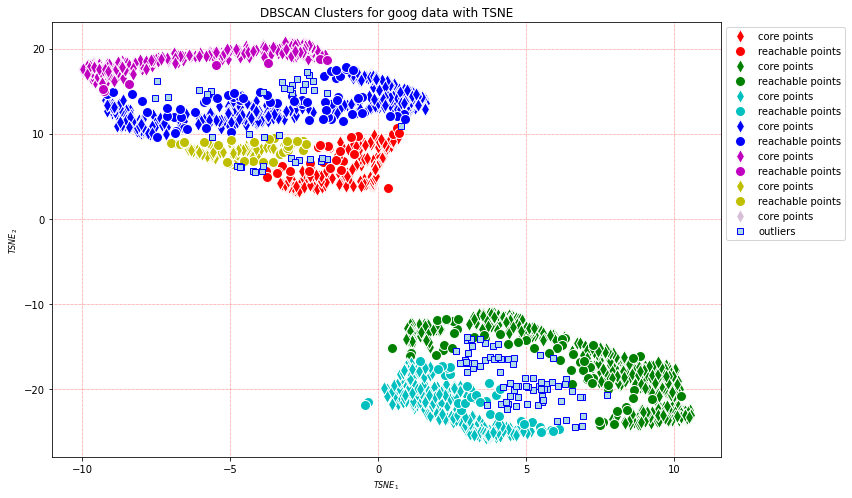

In [ ]:
goog.getTSNE(200, 'pca')
goog.tsneNewData = goog.tsneNewData[:,:2]
goog_tsne_db = DBSCAN(eps=1, min_samples =20).fit(goog.tsneNewData)
plotDB(goog_tsne_db,goog.tsneNewData, 'goog', 'TSNE')

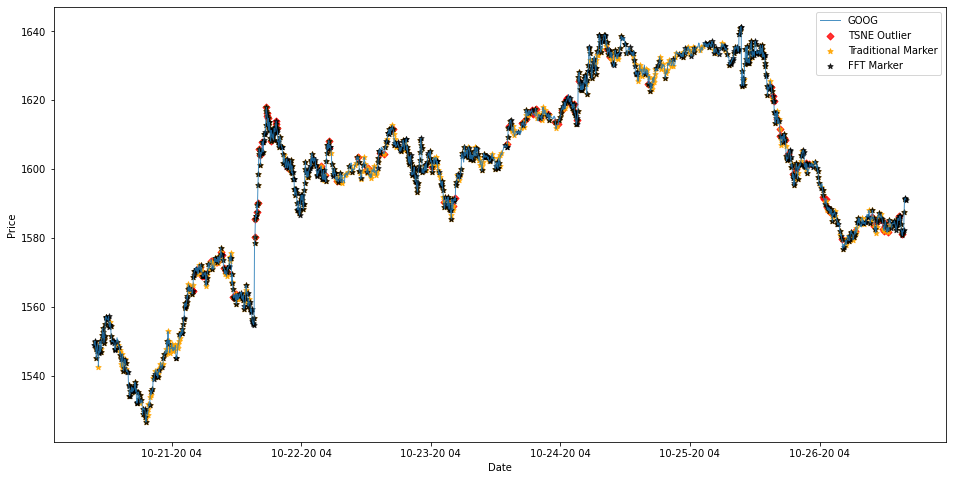

In [ ]:
goog_tsne_markers = (goog_tsne_db.labels_==-1)
plotMarkers(goog_df, 'GOOG', 'TSNE',goog_tsne_markers, goog.global_mask(), goog.fft_mask())

In [ ]:
calcuMse1(goog_df, dateToNumeric(goog_df,goog_df[goog_tsne_markers].index), 
          dateToNumeric(goog_df, goog_truemarker))
calCoverageRate(goog_df[goog_tsne_markers].index,goog_truemarker)

MSE:  0.09147884975308958
Coverage Rate:  0.8173913043478261


20  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1}
outliers:  75


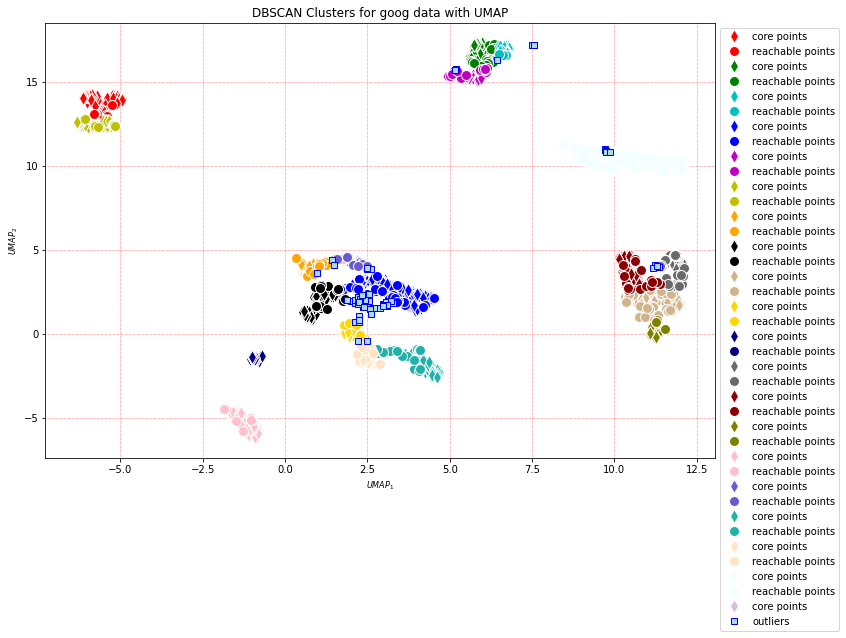

In [ ]:
goog.getUMAP(10, 0.5)
goog.umapNewData = goog.umapNewData[:,:2]
goog_umap_db = DBSCAN(eps=0.4, min_samples =25).fit(goog.umapNewData)
plotDB(goog_umap_db,goog.umapNewData, 'goog', 'UMAP')

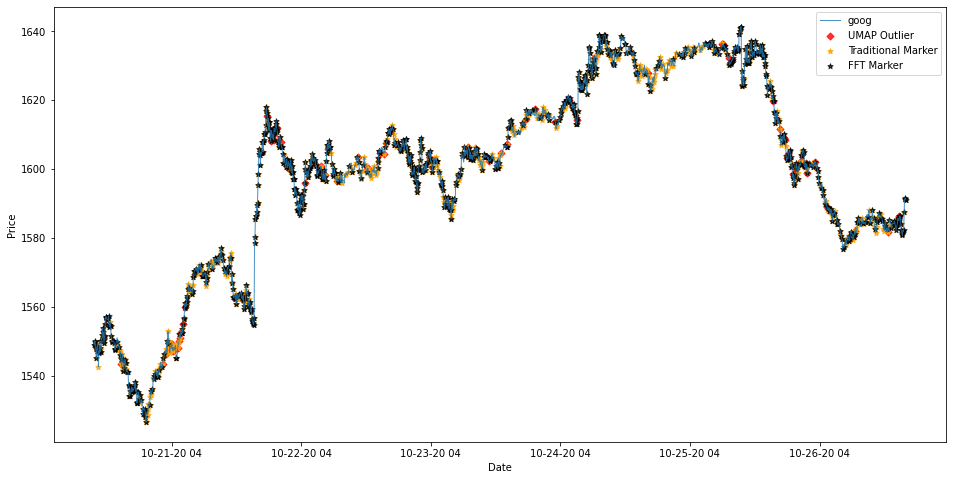

In [ ]:
goog_umap_markers = (goog_umap_db.labels_==-1)
plotMarkers(goog_df, 'goog', 'UMAP',goog_umap_markers, goog.global_mask(), goog.fft_mask())

In [ ]:
calcuMse1(goog_df, dateToNumeric(goog_df,goog_df[goog_umap_markers].index), 
          dateToNumeric(goog_df, goog_truemarker))
calCoverageRate(goog_df[goog_umap_markers].index,goog_truemarker)

MSE:  0.07757568915685017
Coverage Rate:  0.88


4  labels:  {0, 1, 2, -1}
outliers:  102


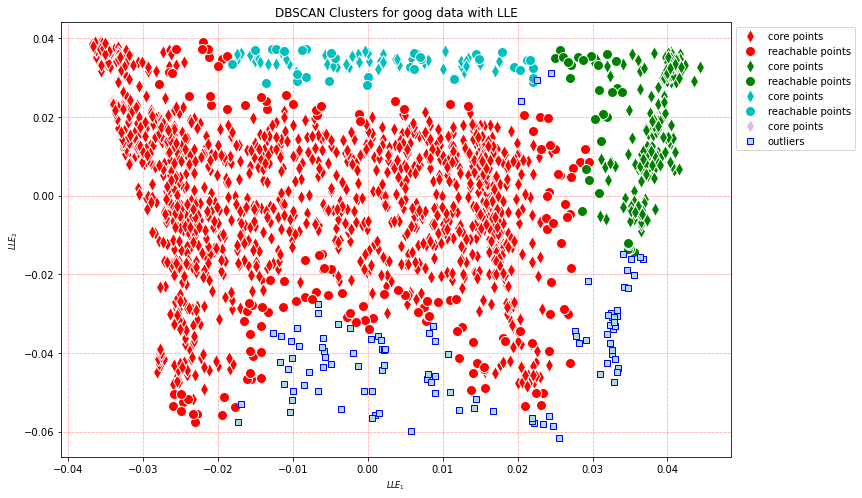

In [ ]:
goog.getLLE(100)
goog.lleNewData = goog.lleNewData[:,:2]
goog_lle_db = DBSCAN(eps=0.006, min_samples =20).fit(goog.lleNewData)
plotDB(goog_lle_db,goog.lleNewData, 'goog', 'LLE')

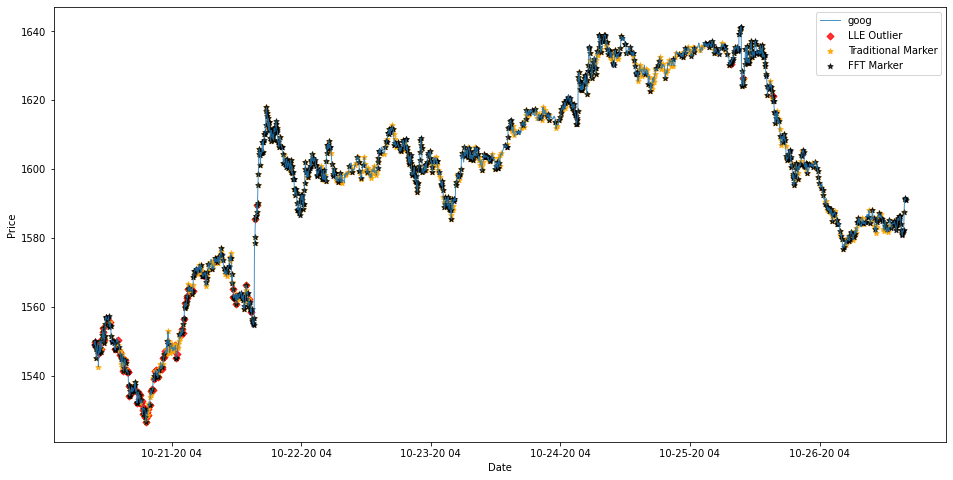

In [ ]:
goog_lle_markers = (goog_lle_db.labels_==-1)
plotMarkers(goog_df, 'goog', 'LLE',goog_lle_markers, goog.global_mask(), goog.fft_mask())

In [ ]:
calcuMse1(goog_df, dateToNumeric(goog_df,goog_df[goog_lle_markers].index), 
          dateToNumeric(goog_df, goog_truemarker))
calCoverageRate(goog_df[goog_lle_markers].index,goog_truemarker)

MSE:  0.08329038628760506
Coverage Rate:  0.7254901960784313


# Intel

In [ ]:
intel = dimension_reduction('intel',intel_df)
intel.fft_trans()

7  labels:  {0, 1, 2, 3, 4, 5, -1}
outliers:  496


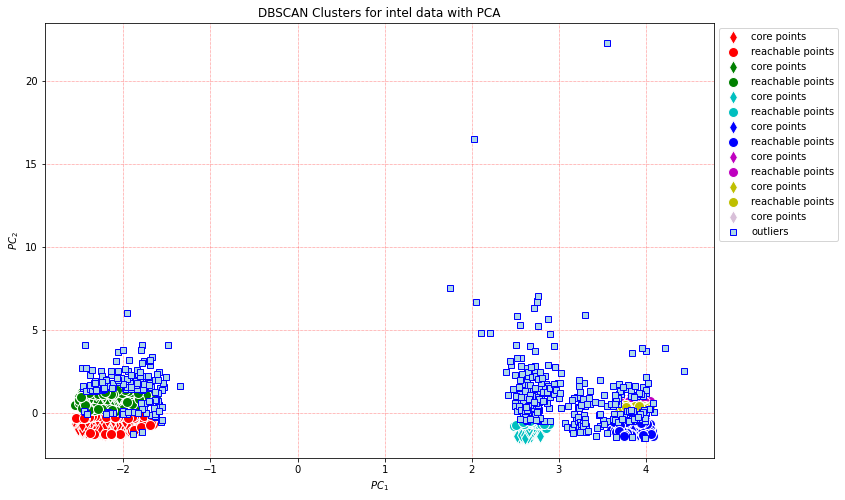

In [ ]:
intel.getPCA()
intel.pcaNewData = intel.pcaNewData[:,:2]
intel_pca_db = DBSCAN(eps=0.2, min_samples =40).fit(intel.pcaNewData)
plotDB(intel_pca_db,intel.pcaNewData, 'intel', 'PCA')

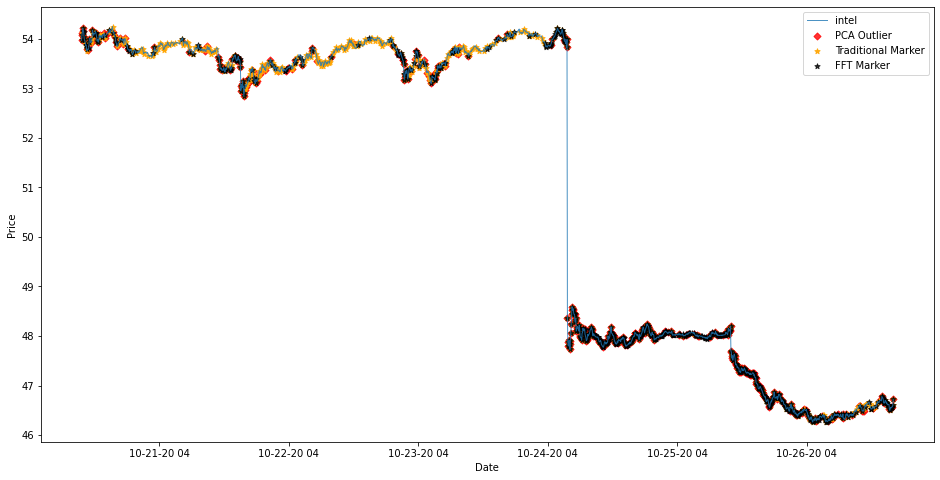

In [ ]:
intel_pca_markers = (intel_pca_db.labels_==-1)
plotMarkers(intel_df, 'intel', 'PCA',intel_pca_markers, intel.global_mask(), intel.fft_mask())

In [ ]:
intel_truemarker = intel.fftRanking.index | intel_df[intel_df['Marker'] == True].index
calcuMse1(intel_df, dateToNumeric(intel_df,intel_df[intel_pca_markers].index), 
          dateToNumeric(intel_df, intel_truemarker))
calCoverageRate(intel_df[intel_pca_markers].index,intel_truemarker)

MSE:  3.817799059165296e-05
Coverage Rate:  0.9375


16  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
outliers:  454


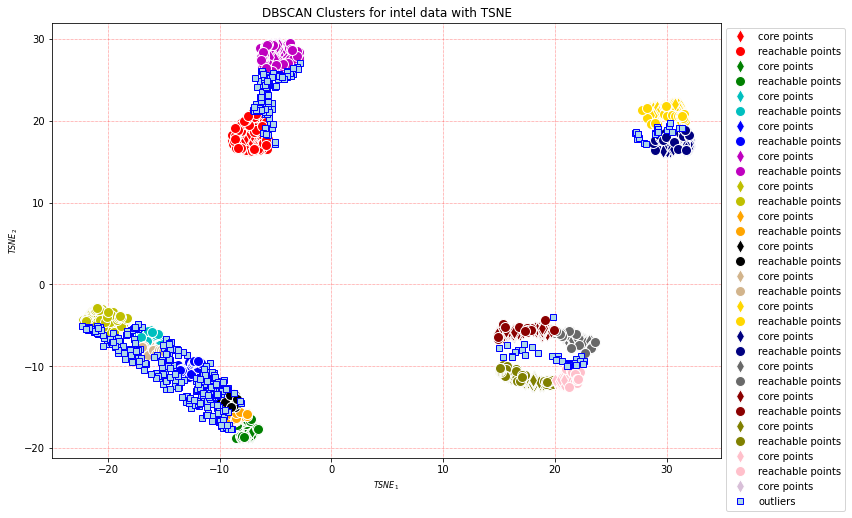

In [ ]:
intel.getTSNE(150, 'pca')
intel.tsneNewData = intel.tsneNewData[:,:2]
intel_tsne_db = DBSCAN(eps=1, min_samples =40).fit(intel.tsneNewData)
plotDB(intel_tsne_db,intel.tsneNewData, 'intel', 'TSNE')

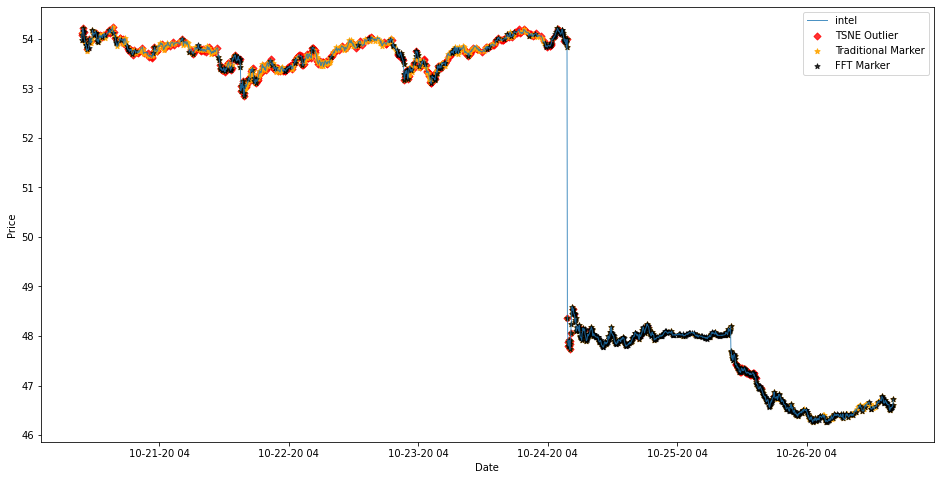

In [ ]:
intel_tsne_markers = (intel_tsne_db.labels_==-1)
plotMarkers(intel_df, 'intel', 'TSNE',intel_tsne_markers, intel.global_mask(), intel.fft_mask())

In [ ]:
calcuMse1(intel_df, dateToNumeric(intel_df,intel_df['marketClose'][intel_tsne_markers].index), 
          dateToNumeric(intel_df, intel_truemarker))
calCoverageRate(intel_df['marketClose'][intel_tsne_markers].index,intel_truemarker)

MSE:  0.0004983594863086278
Coverage Rate:  0.44933920704845814


26  labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}
outliers:  336


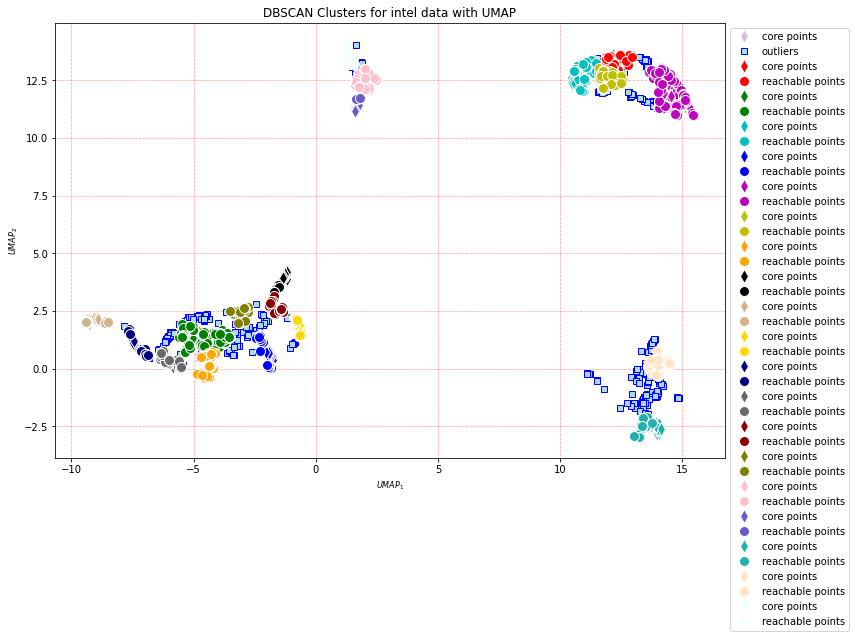

In [ ]:
intel.getUMAP(10, 0.5)
intel.umapNewData = intel.umapNewData[:,:2]
intel_umap_db = DBSCAN(eps=0.4, min_samples =30).fit(intel.umapNewData)
plotDB(intel_umap_db,intel.umapNewData, 'intel', 'UMAP')

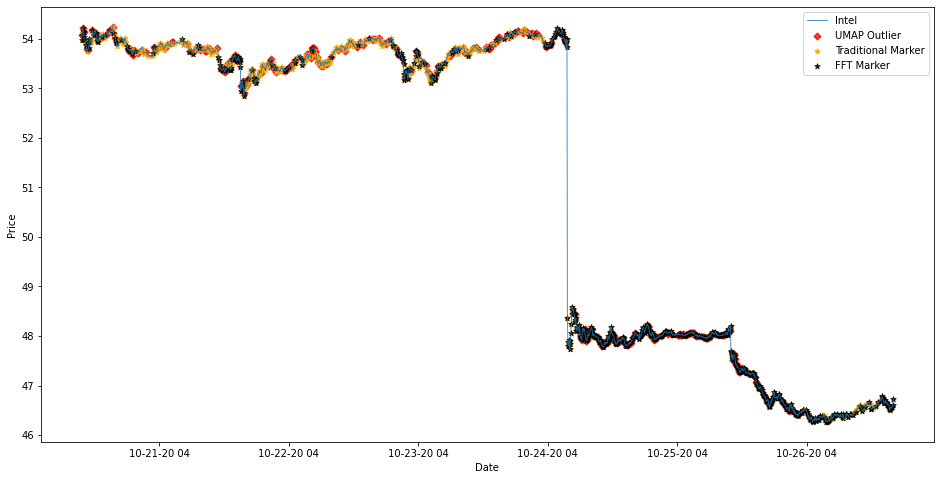

In [ ]:
intel_umap_markers = (intel_umap_db.labels_==-1)
plotMarkers(intel_df, 'Intel', 'UMAP',intel_umap_markers, intel.global_mask(), intel.fft_mask())

In [ ]:
calcuMse1(intel_df, dateToNumeric(intel_df,intel_df[intel_umap_markers].index), 
          dateToNumeric(intel_df, intel_truemarker))
calCoverageRate(intel_df[intel_umap_markers].index,intel_truemarker)

MSE:  0.00030657085703534817
Coverage Rate:  0.5952380952380952


5  labels:  {0, 1, 2, 3, -1}
outliers:  316


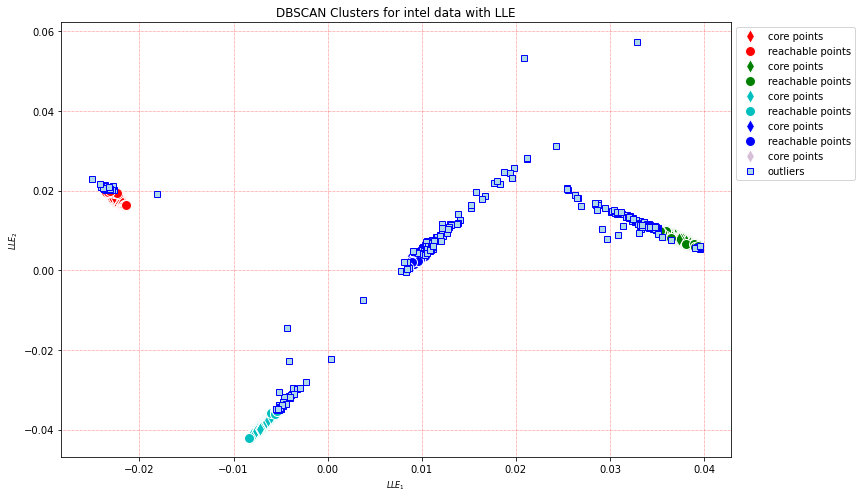

In [ ]:
intel.getLLE(100)
intel.lleNewData = intel.lleNewData[:,:2]
intel_lle_db = DBSCAN(eps=0.0005, min_samples =30).fit(intel.lleNewData)
plotDB(intel_lle_db,intel.lleNewData, 'intel', 'LLE')

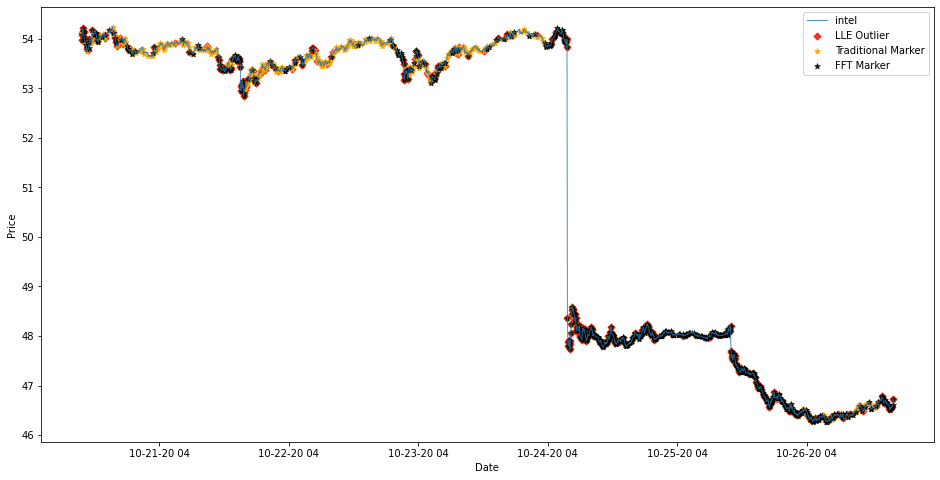

In [ ]:
intel_lle_markers = (intel_lle_db.labels_==-1)
plotMarkers(intel_df, 'intel', 'LLE',intel_lle_markers, intel.global_mask(), intel.fft_mask())

In [ ]:
calcuMse1(intel_df, dateToNumeric(intel_df,intel_df[intel_lle_markers].index), 
          dateToNumeric(intel_df, intel_truemarker))
calCoverageRate(intel_df[intel_lle_markers].index,intel_truemarker)

MSE:  6.244332325877622e-06
Coverage Rate:  0.9683544303797469
